# Study EGOYQN Linelist
The data was collected by Médecin Sans Frontières in Guéckédou, Guinea

The "Line list" is a document which collects primary data such as age,sex, patient id, onset date etc ... It aslo in our case includes the result of the Ebola Test "epistat" and the "outcome" of the patient.

## Summary

Our first goal is to predict whether the patient has ebola or not based on several features given in the data frame []



In [2]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys
#import eli5
sys.path.append('STUDIES')
from proj2_HELPERS_ import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from yellowbrick.features import Manifold
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import FeatureImportances


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
df_linelist = pd.read_csv('../../Original dataset/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_linelist.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../Original dataset/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv'

# Predictions ebola

### Symptoms 

In [3]:
symptoms = ['symfev', 'symn', 'symv', 'symvom', 'symdiar', 'symfat',
       'symanor', 'symdouab', 'symdouth', 'symdoumu', 'symdouar',
       'symceph', 'symtoux', 'symresp', 'symaval', 'symmalg', 'symict',
       'symconj', 'symercut', 'symhoq', 'symorb', 'symcoma', 'symconf',
       'symasth', 'symhemor', 'hemgen', 'heminj', 'hemnez', 'hemsel',
       'hemvoms', 'hemvomn', 'hemtou', 'hemvag', 'hempet', 'hemuri',
       'hemaut', 'contsusp', 'funvis', 'hospvis', 'anicon', 'anitiq']
df_symp = df_linelist[symptoms]

In [4]:
# apply dictionnary to get -1, 0, 1 for df_symp
dict_symp_answer = {'Non' : 'No', 'Oui' : 'Yes', 'Non rempli' : 'Unknown', 
                    'Pas applicable (non inclus dans fiche)' : 'Unknown', 
                    'Unknown' : '-1', 'Nan' : '-1', 'nan' : '-1', '7' : '-1',
                    'na': '-1', '.': '-1', 
                    '8': '-1', '9': '-1', '1':'1', '0':'0', '2':'-1', '3':'-1'}
df_symp = df_symp.astype('str')
df_symp = df_symp.applymap(lambda x : dict_symp_answer[x])

### Sex 

In [5]:
df_sex = df_linelist['sex']
df_sex = df_sex.astype('str')
dict_sex = {'1': '1', '2':'0', '9': '-1'}
df_sex = df_sex.apply(lambda x : dict_sex[x])

### Age 

In [6]:
df_age  = df_linelist['age']
df_age = df_age.replace(999, -1)

### Ebola 

In [7]:
# apply dictionnary to get -1, 0, 1 for df_ebola  --> 0: not a case, 1: ebola, -1: unknown
df_ebola  = df_linelist['epistat']
dict_ebola_answer = {'0':'0', '1':'1', '2':'1', '3':'-1', '9':'-1', '.':'-1'}
df_ebola = df_ebola.astype('str')
df_ebola = df_ebola.apply(lambda x : dict_ebola_answer[x])

### Assemble

In [8]:
# concatenate symptoms, age, sex and ebola
df_ebo = pd.concat([df_age, df_sex, df_symp, df_ebola], axis = 1, join = 'outer').astype('int')

### Feature processing

First drop rows where no symtoms

In [9]:
# convert all -1 to NaN so that we can use the dropna() function
df_ebo.replace(-1, np.nan, inplace=True)
# then drop rows with only nans 
df_ebo.dropna(axis=0, how='all', subset=symptoms, inplace=True)
# convert all NaN to -1 
df_ebo.replace(np.nan, -1, inplace=True)


# then do the same with zeros
#df_ebo.replace(0, np.nan, inplace=True)
#df_ebo.dropna(axis=0, how='all', subset=symptoms, inplace=True)
#df_ebo.replace(np.nan, 0, inplace=True)

df_ebo

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,epistat
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2497,34.0,0.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


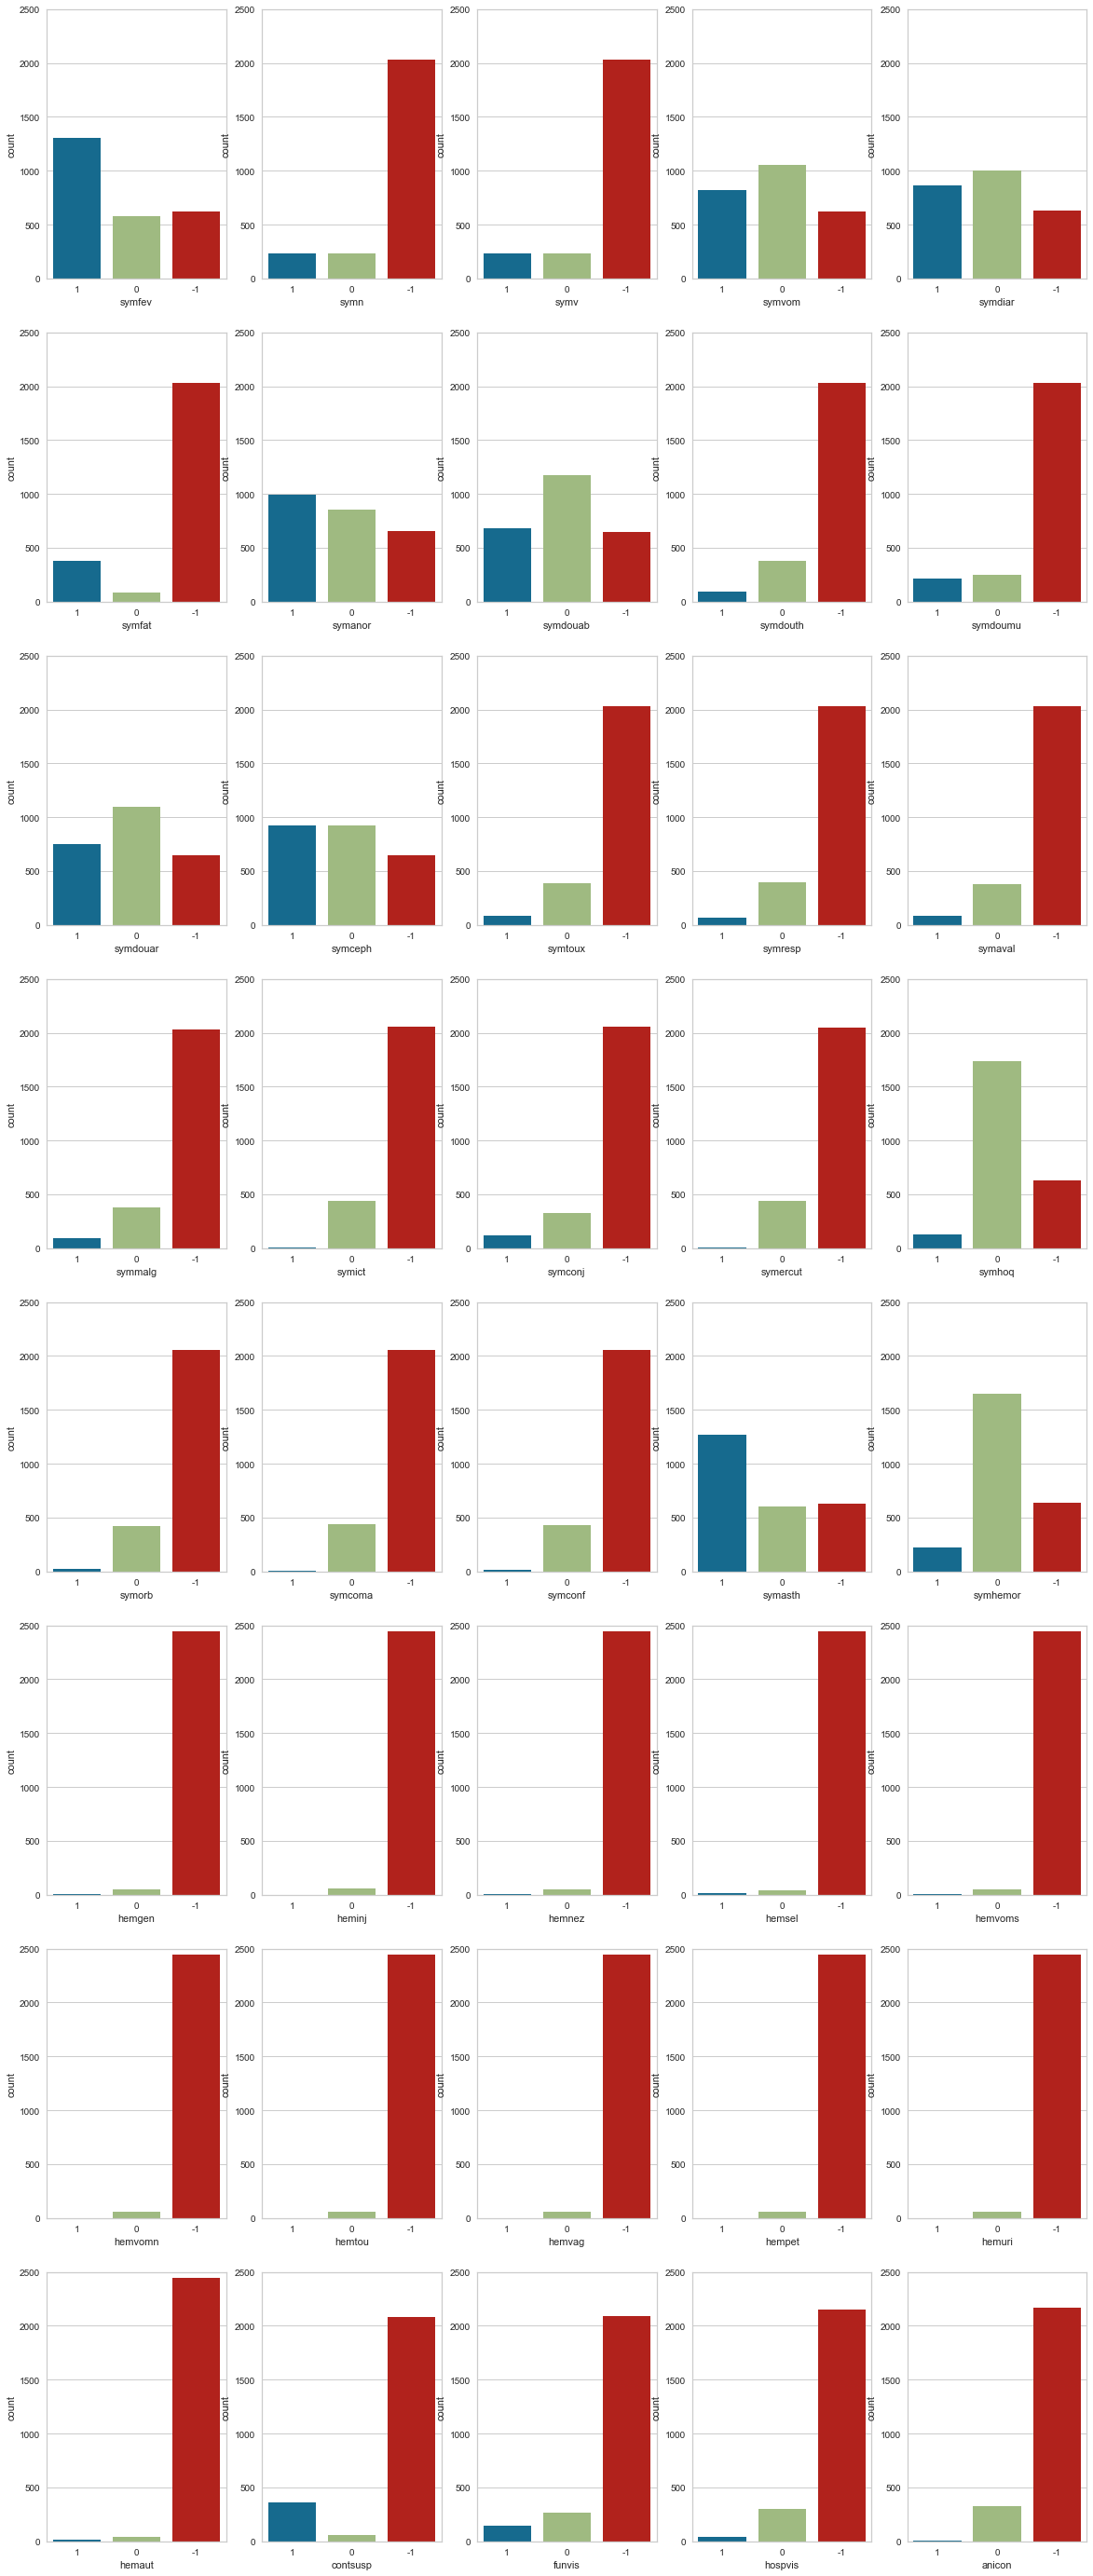

In [10]:
fig, axes = plt.subplots(nrows = 8, ncols=5, figsize=(20,50))
for ax, col in zip(axes.flatten(), df_symp.columns):
    sns.countplot(df_symp[col], ax = ax, order = ['1', '0', '-1'])
    ax.set_ylim(0, 2500)
fig.savefig("symptoms.png")    

## First proposition of data frame

In [11]:
df_ebo_simple = delete_minus1(df_ebo)
df_ebo_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,epistat
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2497,34.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [12]:
remaining_symptoms = ['symfev', 'symvom', 'symdiar', 'symanor', 'symdouab', 'symdouar', 
                      'symceph', 'symhoq', 'symasth', 'symhemor']

# then do the same with zeros
df_ebo_simple.replace(0, np.nan, inplace=True)
df_ebo_simple.dropna(axis=0, how='all', subset=remaining_symptoms, inplace=True)
df_ebo_simple.replace(np.nan, 0, inplace=True)
df_ebo_simple.shape

(1768, 13)

In [13]:
y_ebo_simple = df_ebo_simple['epistat'].astype(float)
X_ebo_simple = df_ebo_simple.drop(['epistat'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


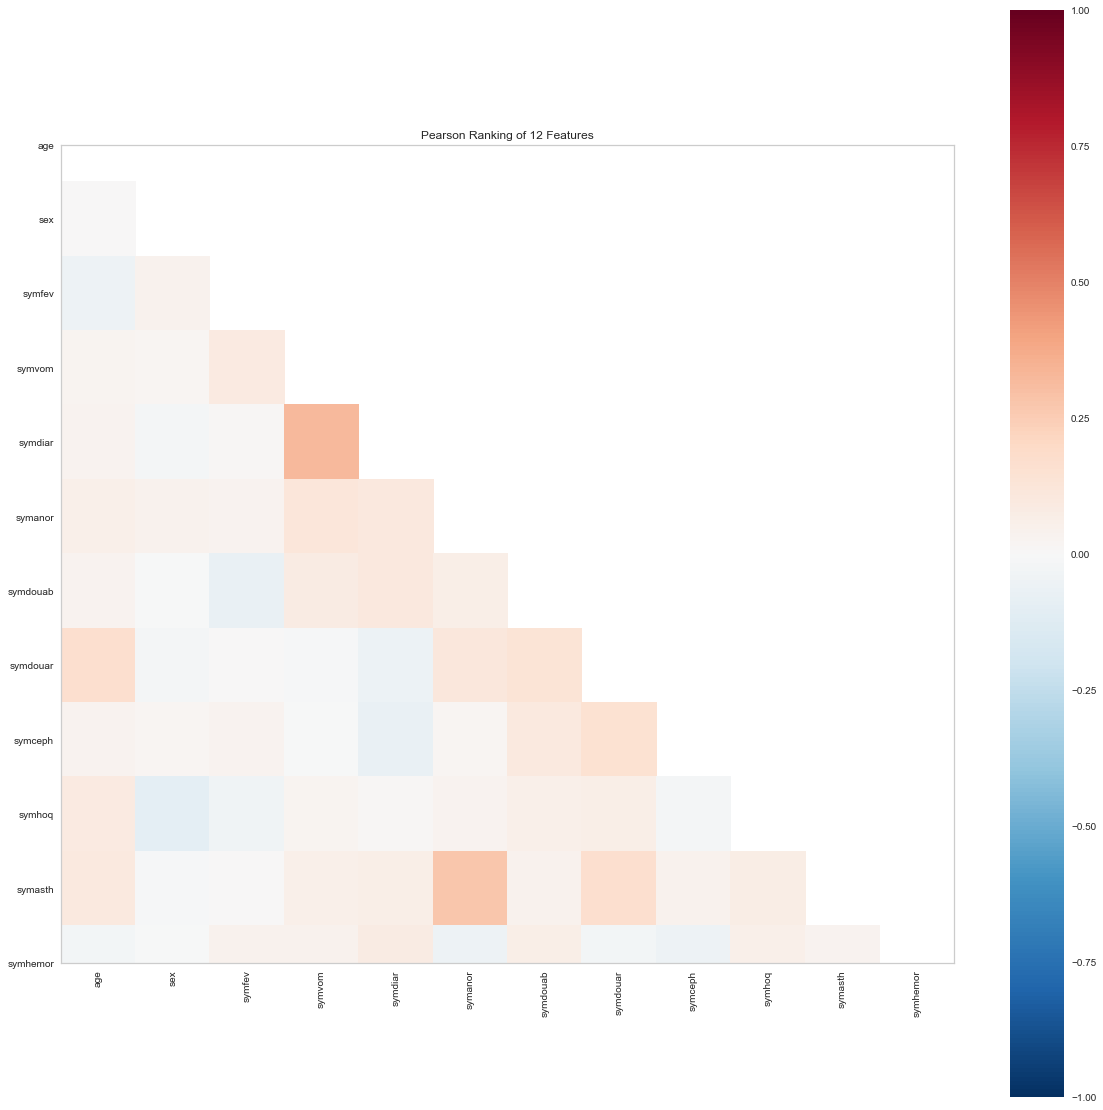

In [14]:
Corr_vision(X_ebo_simple)

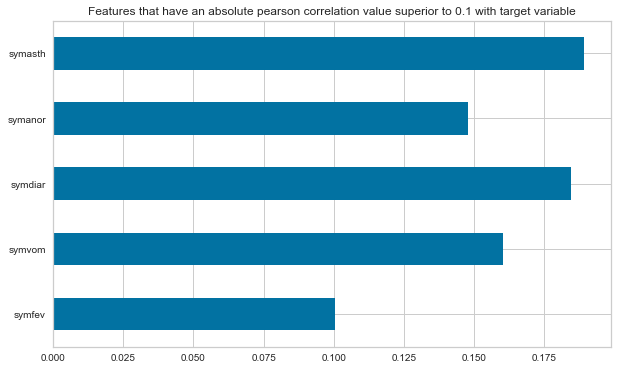

In [15]:
X_y = X_ebo_simple.join(y_ebo_simple)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.1  
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

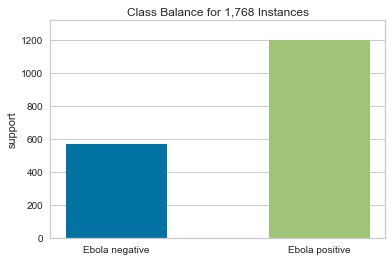

In [16]:
Imbalance(y_ebo_simple)

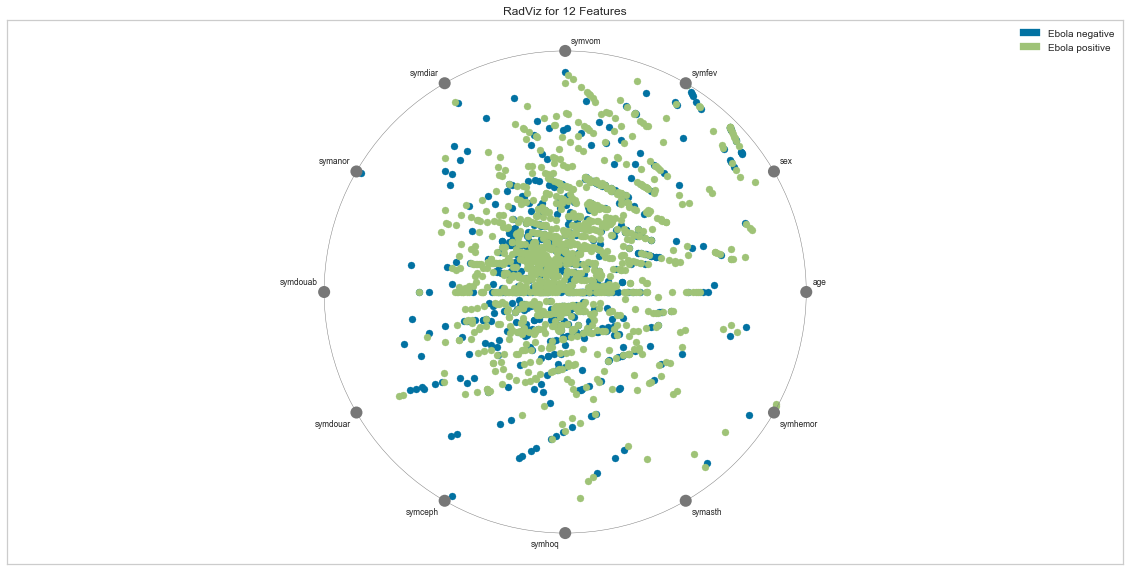

In [17]:
Rad_vision(X_ebo_simple, y_ebo_simple)

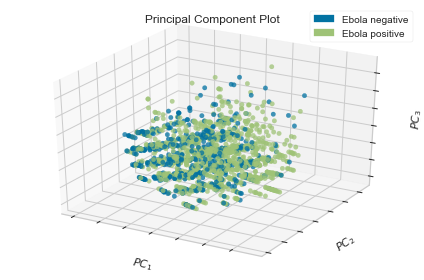

In [18]:
PCA_vision_3D(X_ebo_simple, y_ebo_simple.astype('int'))

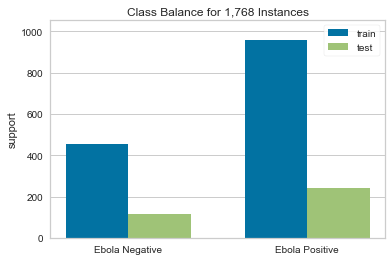

In [19]:
X_ebo_simple_train, X_ebo_simple_test, y_ebo_simple_train, y_ebo_simple_test = train_test_split(X_ebo_simple, y_ebo_simple, test_size=0.2, random_state=123, stratify=y_ebo_simple)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_simple_train, y_ebo_simple_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [20]:
# standardize age for df_ebo_simple

scaler1 = StandardScaler()
X_ebo_simple_train['age'] = scaler1.fit_transform(X_ebo_simple_train['age'].to_numpy().reshape(-1, 1))  
X_ebo_simple_test['age'] = scaler1.transform(X_ebo_simple_test['age'].to_numpy().reshape(-1, 1))

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## ML models here

#### Decision tree

In [21]:
simple_decision_tree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [22]:
gsearch = GridSearchCV(
    estimator= simple_decision_tree,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_simple_train, y_ebo_simple_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10,

In [23]:
clf_best_simple_tree = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_simple_tree.fit(X_ebo_simple_train, y_ebo_simple_train)
y_ebo_simple_pred = clf_best_simple_tree.predict(X_ebo_simple_test)
accuracy_test = accuracy_score(y_ebo_simple_test, y_ebo_simple_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_ebo_simple_test, y_ebo_simple_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

0.6139254385964912

#### Random forest 

In [24]:
param_test = {
    'n_estimators':[20, 30, 40 , 50, 60, 100],
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}
simple_random_forest = RandomForestClassifier(random_state = 123)

In [ ]:
gsearch = GridSearchCV(
    estimator= simple_random_forest,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_simple_train, y_ebo_simple_train)
print(gsearch.best_params_)

In [ ]:
best_simple_random_forest = RandomForestClassifier(
    random_state= 123,
    n_estimators=     gsearch.best_params_['n_estimators'], 
    max_depth=        gsearch.best_params_['max_depth'], 
    min_samples_split=gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=   gsearch.best_params_['max_leaf_nodes']
)
best_simple_random_forest = best_simple_random_forest.fit(X_ebo_simple_train, y_ebo_simple_train)
y_ebo_simple_pred = best_simple_random_forest.predict(X_ebo_simple_test)
accuracy_test = accuracy_score(y_ebo_simple_test, y_ebo_simple_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_ebo_simple_test, y_ebo_simple_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

## Second proposition of data frame

In [ ]:
df_ebo_extra = df_ebo
# delete all rows where y = -1 :
df_ebo_extra = df_ebo_extra[df_ebo_extra['epistat']!=-1]
df_ebo_extra = make_indicators(df_ebo_extra, df_ebo_extra.drop('epistat', axis=1).columns, [-1]*len(df_ebo_extra.drop('epistat', axis=1).columns), False)
df_ebo_extra                                                                                                    

In [ ]:
y_ebo_extra = df_ebo_extra['epistat'].astype(float)
X_ebo_extra = df_ebo_extra.drop(['epistat'], axis = 1).astype(float)

In [ ]:
Corr_vision(X_ebo_extra)

In [ ]:
X_y = X_ebo_extra.join(y_ebo_extra)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.175
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

In [ ]:
Imbalance(y_ebo_extra)

In [ ]:
Rad_vision(X_ebo_extra, y_ebo_extra)

In [ ]:
PCA_vision_3D(X_ebo_extra, y_ebo_extra.astype('int'))

In [ ]:
X_ebo_extra_train, X_ebo_extra_test, y_ebo_extra_train, y_ebo_extra_test = train_test_split(X_ebo_extra, y_ebo_extra, test_size=0.2, random_state=123, stratify=y_ebo_extra)

# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_extra_train, y_ebo_extra_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [ ]:
## standardize age

# change -1 to Nan so that it is not take into account when doing standardization 
X_ebo_extra_train['age'].replace(-1, np.nan, inplace=True)
X_ebo_extra_test['age'].replace(-1, np.nan, inplace=True)

# standardization
scaler2 = StandardScaler()
X_ebo_extra_train['age'] = scaler2.fit_transform(X_ebo_extra_train['age'].to_numpy().reshape(-1, 1))  
X_ebo_extra_test['age'] = scaler2.transform(X_ebo_extra_test['age'].to_numpy().reshape(-1, 1))

# we can rechange nans to -1 
X_ebo_extra_train['age'].replace(np.nan, -1, inplace=True)
X_ebo_extra_test['age'].replace(np.nan, -1, inplace=True)

In [ ]:
# sanity check 
print(sum(X_ebo_extra_train['age_indicator']==0))
print(sum(X_ebo_extra_train['age']==-1))

## ML models here

In [ ]:
extra_decision_tree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [ ]:
gsearch = GridSearchCV(
    estimator= extra_decision_tree,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_extra_train, y_ebo_extra_train)

In [ ]:
clf_best_extra_tree = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_extra_tree.fit(X_ebo_extra_train, y_ebo_extra_train)
y_ebo_extra_pred = clf_best_extra_tree.predict(X_ebo_extra_test)
accuracy_test = accuracy_score(y_ebo_extra_test, y_ebo_extra_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_ebo_extra_test, y_ebo_extra_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

## Third proposition of data frame

In [ ]:
df_ml = pd.read_csv("allFiles/Rid_frame.csv")

df_ml

In [ ]:
X_ebo_ml = df_ml.drop(columns = ['msfid','epistat'])
y_ebo_ml = df_ml['epistat']

#### Correlation matrix 

In [ ]:
Corr_vision(X_ebo_ml)

Let's have a look at high correlation between features and target value.

In [ ]:
X_y = X_ebo_ml.join(y_ebo_ml)
corr_matrix = X_y.corr()

corr_y = corr_matrix['epistat']
threshold = 0.2
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('epistat').plot(kind='barh', fontsize= 15)
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold), fontsize= 15)
plt.show()

The values above are "correlated" with the output variable 'epistat' (ebola outcome), we expect them to be considered important during the model.

### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

In [ ]:
Imbalance(y_ebo_ml)

In [ ]:
Rad_vision(X_ebo_ml, y_ebo_ml)

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

In [ ]:
PCA_vision_3D(X_ebo_ml, y_ebo_ml)

PCA is not giving so much information: no clusters of ebola positive. 

#### We are in a high dimension dataset, let's try Manifold

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Ebola negative', 'Ebola positive'])
viz.fit_transform(X_ebo_ml, y_ebo_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
We need to be careful to standardize the test set with the parameters found during the standardizatio of the training set.

In [ ]:

X_ebo_train, X_ebo_test, y_ebo_train, y_ebo_test = train_test_split(X_ebo_ml, y_ebo_ml, test_size=0.2, random_state=123, stratify=y_ebo_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_train, y_ebo_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [ ]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_ebo_train.loc[:,numerical_col] = scaler3.fit_transform(X_ebo_train[numerical_col])
X_ebo_test.loc[:,numerical_col] = scaler3.transform(X_ebo_test[numerical_col])

### Feature selection 

#### First remove features with low variance

In [ ]:
X_ebo_train.std().hist(bins= 100)

In [ ]:
ebo_col_null_std = X_ebo_train.columns[(X_ebo_train.apply(lambda x : np.std(x)) == 0).values].values
ebo_col_null_std

In [ ]:
X_ebo_train.drop(columns = ebo_col_null_std, inplace = True)
X_ebo_test.drop(columns = ebo_col_null_std, inplace = True)

#### Then remove correlated features

In [ ]:
corr_count = (abs(X_ebo_train.corr()) > 0.8).sum() 

In [ ]:
# function found on https://www.geeksforgeeks.org/find-location-of-an-element-in-pandas-dataframe-in-python/ 
# and slightly modified for our case 
def getIndexes(dfObj, value): 
      
    listOfPos = [] 
    result = dfObj.isin([value]) 
    seriesObj = result.any() 
    columnNames = list(seriesObj[seriesObj == True].index) 
     
    for col in columnNames: 
        rows = list(result[col][result[col] == True].index) 
  
        for row in rows: 
            if col != row:
                listOfPos.append((row, col)) 
              
    return listOfPos 

In [ ]:
corr_temp = abs(X_ebo_train[corr_count[corr_count > 1].index.to_list()].corr()) > 0.8

listOfPositions = getIndexes(corr_temp, True) 
  
print('Index positions of True in Dataframe : ') 
for i in range(len(listOfPositions)): 
    print( listOfPositions[i]) 

With this above list of correlated features we can choose which features we want to remove by hand.

In [ ]:
col_correlated_removed = ['contdat1_dayofyear', 'sex_F', 'Unknown_grp2', 'respref_Beyla', 'respref_Dabola', 'respref_Faranah',
                         'respref_Forécariah', 'respref_Kankan',  'respref_Kissidougou', 'respref_Kouroussa', 'respref_Kérouane',
                          'respref_Lola', 'respref_Nzérékoré']

X_ebo_train.drop(columns = col_correlated_removed, inplace = True)
X_ebo_test.drop(columns = col_correlated_removed, inplace = True)

#### Recursive Feature Elimination (RFE) 

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=250)
logreg.fit(X_ebo_train, y_ebo_train)
rfe = RFE(logreg, n_features_to_select=1)
rfe = rfe.fit(X_ebo_train, y_ebo_train)
order = rfe.ranking_

In [ ]:
sorted(zip(order, X_ebo_train.columns))

In [ ]:
models = [
    LogisticRegression(random_state = 123, solver='lbfgs', max_iter = 300),
    tree.DecisionTreeClassifier(random_state=123),
    RandomForestClassifier(random_state = 123, n_estimators=300),    
    SVC(random_state=123)
]

100 iterations for the logistic regression was not enough so we increased the number of iterations to 300.

In [ ]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
num_features = [i+1 for i in range(X_ebo_train.shape[1])]
results = list()

for k in num_features:

    model = SVC(random_state=123)
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X_ebo_train, y_ebo_train)
    results.append(scores)
    print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

In [ ]:
grid = dict()
grid['anova__k'] = [i+1 for i in range(X_ebo_train.shape[1])]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)
search = GridSearchCV(pipeline, grid, scoring='roc_auc', n_jobs=-1, cv=cv)
results = search.fit(X_ebo_train, y_ebo_train)

print('Best Mean AUC ROC: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

In [ ]:
results.best_params_

In [ ]:
#Redo pipeline with anova_k = above, the best param

In [ ]:
model = LogisticRegression(solver='liblinear')
fs = SelectKBest(score_func=f_classif, k=results.best_params_['anova__k'])
X_train_sel_ftest = fs.fit_transform(X_ebo_train, y_ebo_train)
X_test_sel_ftest = fs.transform(X_ebo_test)
score_model(X_train_sel_ftest, y_ebo_train, X_test_sel_ftest, y_ebo_test, model)

In [ ]:
grid = dict()
grid['anova__k'] = [i+1 for i in range(X_ebo_train.shape[1])]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)

dict_model_ftest_features_number = {}

for model in models:
    pipeline = Pipeline(steps=[('anova',fs), ('model', model)])
    search = GridSearchCV(pipeline, grid, scoring='roc_auc', n_jobs=-1, cv=cv)
    results = search.fit(X_ebo_train, y_ebo_train)
    print("{}:".format(model.__class__.__name__))
    print('Best Mean AUC ROC: %.3f' % results.best_score_)
    print('Best Config: %s' % results.best_params_)
    dict_model_ftest_features_number[model] = results.best_params_

In [ ]:
for model in models: 
    print(model)
    print(dict_model_ftest_features_number[model]['anova__k'])
    fs = SelectKBest(score_func=f_classif, k=dict_model_ftest_features_number[model]['anova__k'])
    print(fs)
    X_train_sel_ftest = fs.fit_transform(X_ebo_train, y_ebo_train)
    X_test_sel_ftest = fs.transform(X_ebo_test)
    score_model(X_train_sel_ftest, y_ebo_train, X_test_sel_ftest, y_ebo_test, model)

### Machine Learning Models

### SVM

For a linear kernel, we just need to optimize the c parameter. However, if we want to use an RBF kernel, both c and gamma parameter need to optimized simultaneously.
So in our case we tune both hyperparameters.

In [ ]:
# Validation curve for gamma parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

param_range = np.logspace(-4, 0, 30)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
param_range = np.logspace(-1, 2, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# Found above
best_k = dict_model_ftest_features_number[models[3]]['anova__k']
# Still need to run SVC
# We will run only rbf as we expect it to be the best and otherwise takes too long to run
parameters = {'anova__k': [best_k] ,'model__kernel':['rbf'], 'model__C': np.logspace(0, 2, 30), 'model__gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC(random_state=123)


fs = SelectKBest(score_func=f_classif, k= best_k)
pipeline = Pipeline(steps=[('anova',fs), ('model', svc)])

## Find scores and best parameters 
fit_best = fs.fit(X_ebo_train,y_ebo_train)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

clf = GridSearchCV(pipeline, parameters, scoring = 'roc_auc', n_jobs=-1, cv = cv)

clf.fit(X_ebo_train, y_ebo_train)

In [ ]:
clf.best_score_

In [ ]:
svc = svm.SVC(
    random_state=123,
    C= clf.best_params_['model__C'], 
    gamma = clf.best_params_['model__gamma'], 
    kernel = clf.best_params_['model__kernel']
)


### Add the fs.transform and fs.transform_fit
X_train_sel_ftest = fs.fit_transform(X_ebo_train, y_ebo_train)
X_test_sel_ftest = fs.transform(X_ebo_test)

score_model(X_train_sel_ftest, y_ebo_train, X_test_sel_ftest, y_ebo_test, svc)


##### The most important features are the following

In [ ]:
X_ebo_train.columns[fs.get_support()]

In [ ]:
#### Scores of most important features


dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_ebo_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
feat_score_svm = featureScores.nlargest(best_k,'Score')
print(featureScores.nlargest(best_k,'Score'))  #print 10 best features
eli5.show_weights(svc, feature_names=list(X_ebo_ml.columns))

This gives the weight associated to each feature, i.e. contribution of each feature into predicting that the class will be y=1 (the patient has ebola).

### Logistic regression

Logistic regression does not really have any critical hyperparameters to tune. But we can add a penalty term (regularization) whose strength is C. 

In [ ]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123)
param_range = np.logspace(-2, 1, 20)

viz = ValidationCurve(LogisticRegression(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# Found above
best_k = dict_model_ftest_features_number[models[0]]['anova__k']
# Still need to run SVC
# We will run only rbf as we expect it to be the best and otherwise takes too long to run
parameters = {'anova__k': [best_k] ,'model__penalty': ['l1', 'l2'], 'model__C' : np.logspace(-2, 1, 30)}
logit = LogisticRegression(random_state=123)


fs = SelectKBest(score_func=f_classif, k= best_k)
pipeline = Pipeline(steps=[('anova',fs), ('model', logit)])

## Find scores and best parameters 
fit_best = fs.fit(X_ebo_train, y_ebo_train)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

clf = GridSearchCV(pipeline, parameters, scoring = 'roc_auc', n_jobs=-1, cv = cv)

clf.fit(X_ebo_train, y_ebo_train)

In [ ]:
clf.best_params_

In [ ]:
logit = LogisticRegression(
    random_state = 123,
    penalty = clf.best_params_['model__penalty'], 
    C = clf.best_params_['model__C']
)

X_train_sel_ftest = fs.fit_transform(X_ebo_train, y_ebo_train)
X_test_sel_ftest = fs.transform(X_ebo_test)

score_model(X_train_sel_ftest, y_ebo_train, X_test_sel_ftest, y_ebo_test, logit)

##### The most important features are the following

In [ ]:
X_ebo_train.columns[fs.get_support()]

In [ ]:
#### Scores of most important features
dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_ebo_train.columns)

#concat two dataframes for better visualization 

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

feat_score_logit = featureScores.nlargest(best_k,'Score')
print(featureScores.nlargest(best_k,'Score'))  #print 10 best features
eli5.show_weights(logit, feature_names=list(X_ebo_ml.columns))

### Random Forest

Please note that even with repeated stratified K folds we get quite a high variance, we also tried using the important features that were given using a f_classic function to remove all but the highest k scoring features

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
param_range = [1,20,30, 40,50,60,100,120]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="n_estimators", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# For max_depth
param_range = np.arange(3,18)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# For min_samples_split

param_range = range(2,50)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# For max_leaf_nodes
param_range = [21, 23, 25, 28, 30, 33, 35, 38, 40, 42, 45, 48, 50, 52, 55, 60]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_leaf_nodes", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# Found above
best_k = dict_model_ftest_features_number[models[2]]['anova__k']

clforest = RandomForestClassifier(random_state = 123)
param_test = {
    'anova__k': [best_k] ,
    'model__n_estimators':[30, 40, 50, 60, 100],
    'model__max_depth':[i for i in range(3, 15)],
    'model__min_samples_split':[i for i in range(2, 10)],
    'model__max_leaf_nodes': [35, 38, 40, 42, 45, 48, 50, 52, 55, 60, 70]
}

fs = SelectKBest(score_func=f_classif, k= best_k)
print(fs)
pipeline = Pipeline(steps=[('anova',fs), ('model', clforest)])

## Find scores and best parameters 
fit_best = fs.fit(X_ebo_train, y_ebo_train)


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
gsearch = GridSearchCV(estimator= pipeline, param_grid= param_test, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv )
gsearch.fit(X_ebo_train, y_ebo_train)
print(gsearch.best_params_)

In [ ]:
clf_best = RandomForestClassifier(n_estimators=     gsearch.best_params_['model__n_estimators'], 
                                  max_depth=        gsearch.best_params_['model__max_depth'], 
                                  min_samples_split=gsearch.best_params_['model__min_samples_split'],
                                  max_leaf_nodes = gsearch.best_params_['model__max_leaf_nodes'],
                                 random_state = 123)

X_train_sel_ftest = fs.fit_transform(X_ebo_train, y_ebo_train)
X_test_sel_ftest = fs.transform(X_ebo_test)

score_model(X_train_sel_ftest, y_ebo_train, X_test_sel_ftest, y_ebo_test, clf_best)


#### Important features 

In [ ]:
X_ebo_train.columns[fs.get_support()]

In [ ]:
#### Scores of most important features

dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_ebo_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

feat_score_RF = featureScores.nlargest(best_k,'Score')

print(featureScores.nlargest(best_k,'Score'))  #print 10 best features
eli5.show_weights(clforest, feature_names=list(X_ebo_ml.columns))

### Decision tree


In [ ]:
# For max_depth
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)

param_range = [1,2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# For min_samples_split

param_range = range(2,50) 

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# Found above
best_k = dict_model_ftest_features_number[models[1]]['anova__k']

cltree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'anova__k': [best_k] ,
    'model__max_depth':[i for i in range(3, 15)], 
    'model__min_samples_split':[i for i in range(2, 15)],
}

fs = SelectKBest(score_func=f_classif, k= best_k)
print(fs)
pipeline = Pipeline(steps=[('anova',fs), ('model', cltree)])

## Find scores and best parameters 
fit_best = fs.fit(X_ebo_train, y_ebo_train)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
gsearch = GridSearchCV(estimator= pipeline, param_grid= param_test, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv )
gsearch.fit(X_ebo_train, y_ebo_train)
print(gsearch.best_params_)

In [ ]:
clf_best = RandomForestClassifier(max_depth=        gsearch.best_params_['model__max_depth'], 
                                  min_samples_split=gsearch.best_params_['model__min_samples_split'],
                                 random_state = 123)

X_train_sel_ftest = fs.fit_transform(X_ebo_train, y_ebo_train)
X_test_sel_ftest = fs.transform(X_ebo_test)

score_model(X_train_sel_ftest, y_ebo_train, X_test_sel_ftest, y_ebo_test, clf_best)

#### Important features

In [ ]:
X_out_train.columns[fs.get_support()]

In [ ]:
#### Scores of most important features



dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_ebo_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

feat_score_RF = featureScores.nlargest(best_k,'Score')

print(featureScores.nlargest(best_k,'Score'))  #print 10 best features
eli5.show_weights(cltree, feature_names=list(X_ebo_ml.columns))

# Old models below: check that results are worst 

#### A quick logistic regression 

 Use of validation curve to determine a plausible area for the hyper-parameters:
- penalty: norm used for the penalization
- C: inverse of regularization strength

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)
param_range = np.logspace(-5, 2, 20)

viz = ValidationCurve(LogisticRegression(), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

With a StratifiedKFold the variance was much too high so we chose to repeat this StratifiedKFold 5 times using the RepeatedStratifiedKFold command. This decreased the variance significantly.

Following the previous remark on variance, we will use RepeatedStratifiedKFold for the next models as soon as the calculation time allows it.   

In [ ]:
parameters = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-1, 0, 20)}
logit = LogisticRegression()

clf = GridSearchCV(logit, parameters, scoring = 'roc_auc', n_jobs=-1, cv = cv)
clf.fit(X_ebo_train, y_ebo_train)
clf.best_params_

In [ ]:
logit = LogisticRegression(penalty = clf.best_params_['penalty'], C = clf.best_params_['C'])
logit.fit(X_ebo_train, y_ebo_train)
y_ebo_pred = logit.predict(X_ebo_test)
accuracy_test = accuracy_score(y_ebo_test, y_ebo_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_ebo_test, y_ebo_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test


In [ ]:
eli5.show_weights(logit, feature_names=list(X_ebo_ml.columns))

In [ ]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(logit, relative=True)
viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

### Decision tree

     Use of validation curve to determine a plausible area for the hyper-parameters
- max_depth: Maximum depth of tree
- min_samples_split: Data points in nodes before split occurs 

In [ ]:
# For max_depth
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)

param_range = [1,2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()


In [ ]:
# For min_samples_split

param_range = range(2,50) 

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
clftree = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(5, 15)],
    'min_samples_split':[i for i in range(2, 20)]
}

In [ ]:
gsearch = GridSearchCV(
    estimator= clftree,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=cv
)
gsearch.fit(X_ebo_train, y_ebo_train)
print(gsearch.best_params_)

In [ ]:
clf_best_tree = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=gsearch.best_params_['max_depth'], 
    min_samples_split=gsearch.best_params_['min_samples_split'])
clf_best_tree.fit(X_ebo_train, y_ebo_train)
y_ebo_pred = clf_best_tree.predict(X_ebo_test)
accuracy_test = accuracy_score(y_ebo_test, y_ebo_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_ebo_test, y_ebo_pred)
auc_test = auc(fpr_test, tpr_test)
print(auc_test)
print(accuracy_test)

### Random Forest 

    Use of validation curve to determine a plausible area for the hyper-parameters
- n_estimators: Number of trees to build
- max_depth: Maximum depth of tree
- min_samples_split: Data points in nodes before split occurs 

With only 5 repetitions the variance was too high so we increased the number of repetitions to 10. This did not significantly reduce the variance so we kept 5 repetitions to limit the calculation time. 


#### Hyperparameter tuning for random forest

Now that we have found ranges for the parameters, let's proceed with a cross validation.
Please bare in mind, that these ranges above were given for one hyper-parameter, when combined with multiple others, we should enlarge the range of each one.


### SVM

Use of validation curve to determine a plausible area for the hyper-parameters
- gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
- C: Regularization parameter (the strength of the regularization is inversely proportional to C)
- kernel: kernel type to be used in the algorithm

For a linear kernel, we just need to optimize the c parameter. However, if we want to use an RBF kernel, both c and gamma parameter need to optimized simultaneously.
So in our case we tune both hyperparameters.

In [ ]:
# Validation curve for gamma parameter 
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=123)
param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=123)
#cv = StratifiedKFold(n_splits=2, random_state=123)
param_range = np.logspace(-1, 2, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(1, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC(random_state=123)

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf.fit(X_ebo_train, y_ebo_train)

In [ ]:
clf.best_params_

In [ ]:
svc = svm.SVC(
    random_state = 123,
    C =      clf.best_params_['C'], 
    gamma =  clf.best_params_['gamma'], 
    kernel = clf.best_params_['kernel'])
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, svc)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=123)
#cv = StratifiedKFold(n_splits=2, random_state=123)

parameters = {'C': np.logspace(1, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc_linear = svm.SVC(random_state=123)

clf_linear = GridSearchCV(svc_linear, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf_linear.fit(X_ebo_train, y_ebo_train)

In [ ]:
clf_linear.best_params_

In [ ]:
svc_linear = svm.SVC(
    random_state = 123,
    C =      clf.best_params_['C'], 
    gamma =  clf.best_params_['gamma'], 
    kernel = 'linear')
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, svc_linear)

In [ ]:
eli5.show_weights(svc_linear, feature_names=list(X_ebo_ml.columns))

In [ ]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(svc_linear, relative=True)
viz.fit(X_ebo_train, y_ebo_train)
viz.show()
plt.show()

In [80]:
############################################################################################################################################

# Predictions outcome

### Outcome 

In [81]:
# apply dictionnary to get -1, 0, 1 for df_outcome  --> 0: recovery, 1: death, -1: unknown
df_outcome  = df_linelist['outcome']
dict_outcome_answer = {'1':'0', '2':'1', '3':'-1', '4':'-1', '9':'-1', '.':'-1'}
df_outcome = df_outcome.astype('str')
df_outcome = df_outcome.apply(lambda x : dict_outcome_answer[x])

### Assemble

In [82]:
# concatenate symptoms, age, sex and outcome (also add epistat so that we only keep ebola positive people)
df_out = pd.concat([df_age, df_sex, df_symp, df_outcome, df_ebola], axis = 1, join = 'outer').astype('int')
df_out = df_out[df_out['epistat']!=0]
df_out = df_out[df_out['epistat']!=-1]
print(df_out['epistat'].value_counts())
df_out.drop('epistat', axis=1, inplace = True)

# add constant column --> only for linear regression, SVM, etc
#df_out = sm.add_constant(df_out).astype('int')
df_out

1    1507
Name: epistat, dtype: int64


,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,outcome
0,60,0,1,-1,-1,1,0,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,35,0,1,-1,-1,1,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,40,1,1,-1,-1,0,0,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,40,1,1,-1,-1,0,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,8,0,1,-1,-1,0,1,-1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26,1,1,-1,-1,1,1,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2495,-1,0,0,-1,-1,1,1,-1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2496,43,1,0,-1,-1,0,1,-1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2498,6,1,1,-1,-1,0,0,-1,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


### Feature processing

In [83]:
# first convert all -1 to NaN so that we can use the dropna() function
df_out.replace(-1, np.nan, inplace=True)
# then drop columns with only nans 
df_out.dropna(axis=0, how='all', subset=symptoms, inplace=True)
# convert all NaN to -1 
df_out.replace(np.nan, -1, inplace=True)

# then do the same with zeros
df_out.replace(0, np.nan, inplace=True)
df_out.dropna(axis=0, how='all', subset=symptoms, inplace=True)
df_out.replace(np.nan, 0, inplace=True)

df_out 

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemvag,hempet,hemuri,hemaut,contsusp,funvis,hospvis,anicon,anitiq,outcome
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


## First proposition of data frame

In [84]:
df_out_simple = delete_minus1(df_out)
df_out_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,45.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [85]:
remaining_symptoms = ['symfev', 'symvom', 'symdiar', 'symanor', 'symdouab', 'symdouar', 
                      'symceph', 'symhoq', 'symasth', 'symhemor']

# then do the same with zeros
df_out_simple.replace(0, np.nan, inplace=True)
df_out_simple.dropna(axis=0, how='all', subset=remaining_symptoms, inplace=True)
df_out_simple.replace(np.nan, 0, inplace=True)
df_out_simple

,age,sex,symfev,symvom,symdiar,symanor,symdouab,symdouar,symceph,symhoq,symasth,symhemor,outcome
1,35.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,12.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493,45.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2494,26.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,43.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2498,6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [86]:
y_out_simple = df_out_simple['outcome'].astype(float)
X_out_simple = df_out_simple.drop(['outcome'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


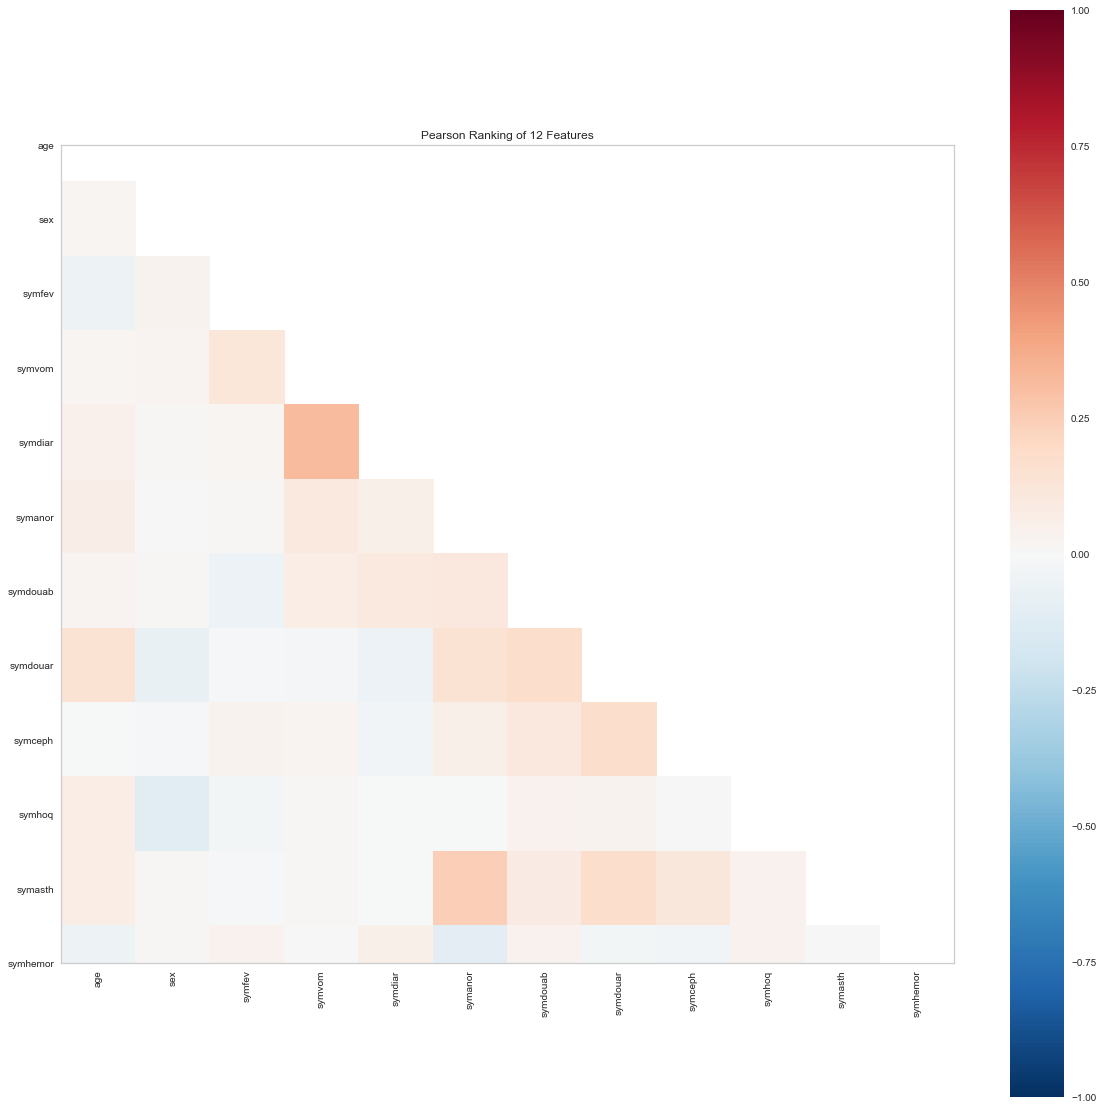

In [87]:
Corr_vision(X_out_simple)

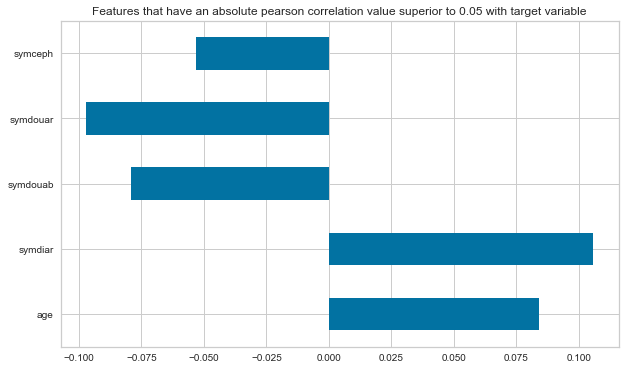

In [88]:
X_y = X_out_simple.join(y_out_simple)
corr_matrix = X_y.corr()

corr_y = corr_matrix['outcome']
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

In [365]:
y_out_simple.value_counts()

1.0    760
0.0    433
Name: outcome, dtype: int64

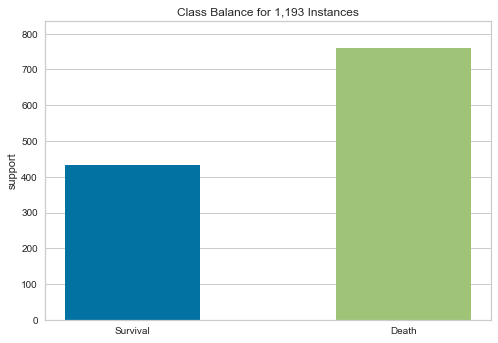

In [89]:
Imbalance_out(y_out_simple)

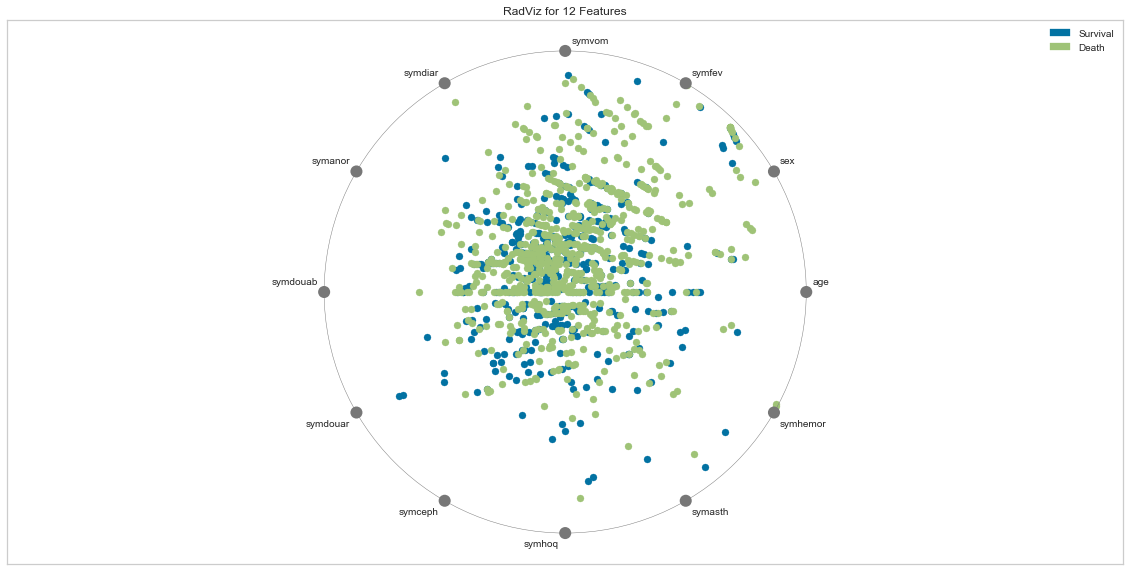

In [90]:
Rad_vision_out(X_out_simple, y_out_simple)

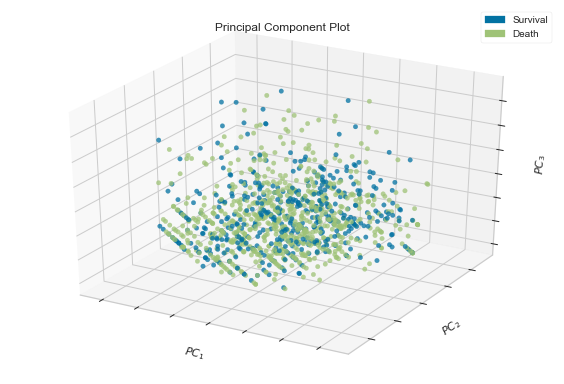

In [91]:
PCA_vision_3D_out(X_out_simple, y_out_simple.astype('int'))

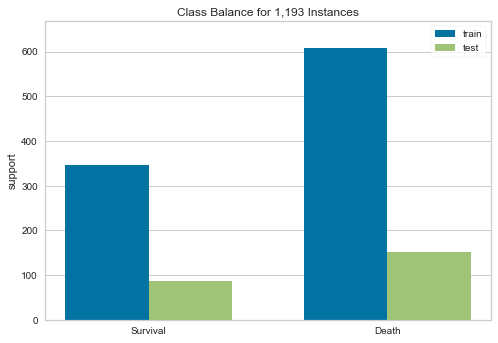

In [92]:
X_out_simple_train, X_out_simple_test, y_out_simple_train, y_out_simple_test = train_test_split(X_out_simple, y_out_simple, test_size=0.2, random_state=123, stratify=y_out_simple)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_simple_train, y_out_simple_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [93]:
# standardize age for df_out_simple

scaler1 = StandardScaler()
X_out_simple_train['age'] = scaler1.fit_transform(X_out_simple_train['age'].to_numpy().reshape(-1, 1))  
X_out_simple_test['age'] = scaler1.transform(X_out_simple_test['age'].to_numpy().reshape(-1, 1))

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### ML models

In [94]:
simple_decision_tree_out = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [95]:
gsearch = GridSearchCV(
    estimator= simple_decision_tree_out,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_out_simple_train, y_out_simple_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10,

In [288]:
clf_best_simple_tree_out = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_simple_tree_out.fit(X_out_simple_train, y_out_simple_train)
y_out_simple_pred = clf_best_simple_tree_out.predict(X_out_simple_test)
accuracy_test = accuracy_score(y_out_simple_test, y_out_simple_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_simple_test, y_out_simple_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

0.5450695704779189

## Second proposition of data frame

In [97]:
df_out_extra = df_out
df_out_extra = df_out_extra[df_out_extra['outcome']!=-1]     
# delete all rows where y = -1:
df_out_extra = make_indicators(df_out_extra, df_out_extra.drop('outcome', axis=1).columns, [-1]*len(df_out_extra.drop('outcome', axis=1).columns), False)   # apply Cédric's function
df_out_extra

,age,sex,symfev,symn,symv,symvom,symdiar,symfat,symanor,symdouab,...,hemtou_indicator,hemvag_indicator,hempet_indicator,hemuri_indicator,hemaut_indicator,contsusp_indicator,funvis_indicator,hospvis_indicator,anicon_indicator,anitiq_indicator
0,60.0,0.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35.0,0.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,26.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2495,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,43.0,1.0,0.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,6.0,1.0,1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# sanity check 
print(sum(df_out_extra['age_indicator']==0))
print(sum(df_out_extra['age']==-1))

print(sum(df_out_extra['outcome']==0))
print(sum(df_out_extra['outcome']==1))

7
7
446
821


In [99]:
y_out_extra = df_out_extra['outcome'].astype(float)
X_out_extra = df_out_extra.drop(['outcome'], axis = 1).astype(float)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


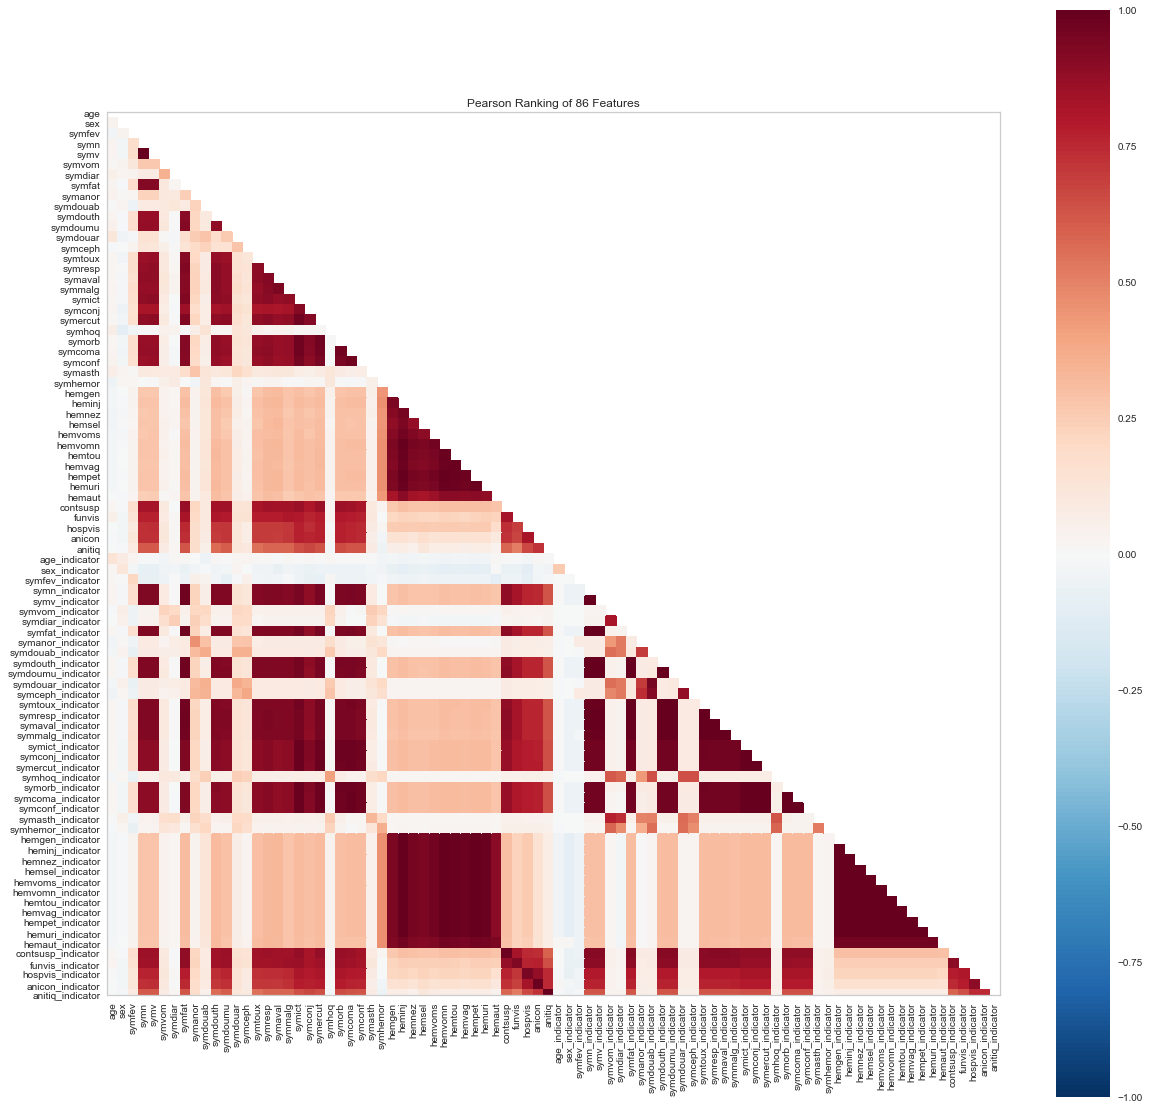

In [100]:
Corr_vision(X_out_extra)

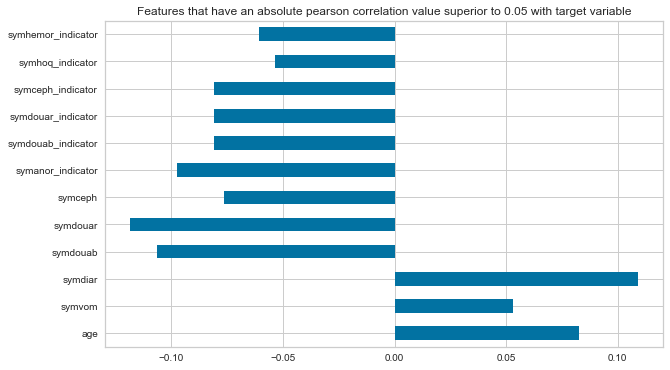

In [101]:
X_y = X_out_extra.join(y_out_extra)
corr_matrix = X_y.corr()

corr_y = corr_matrix['outcome']
threshold = 0.05
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

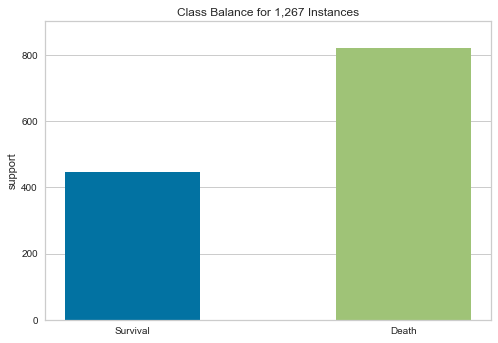

In [102]:
Imbalance_out(y_out_extra)

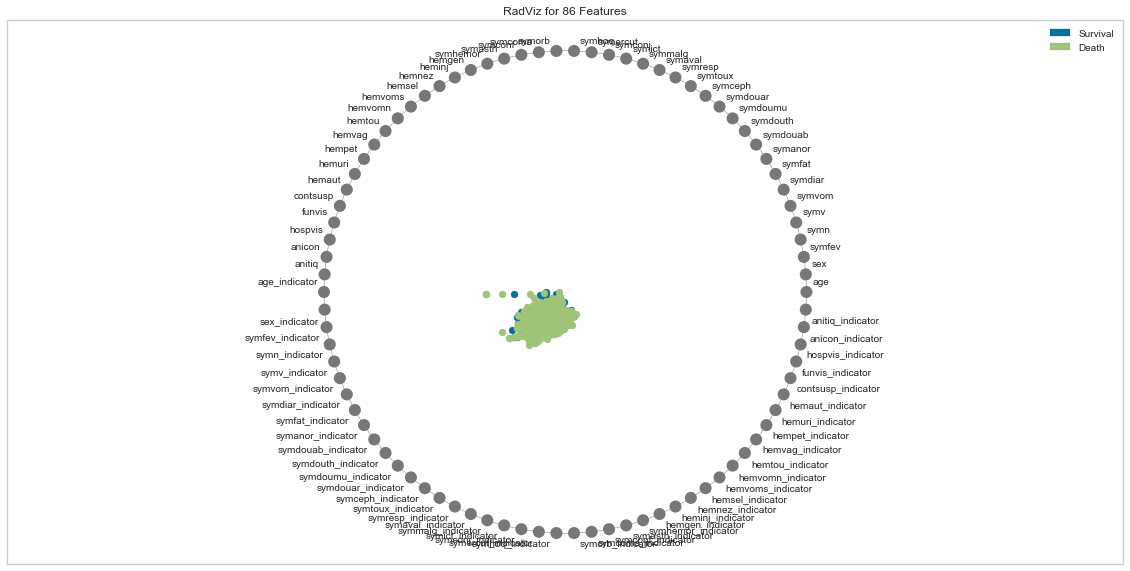

In [103]:
Rad_vision_out(X_out_extra, y_out_extra)

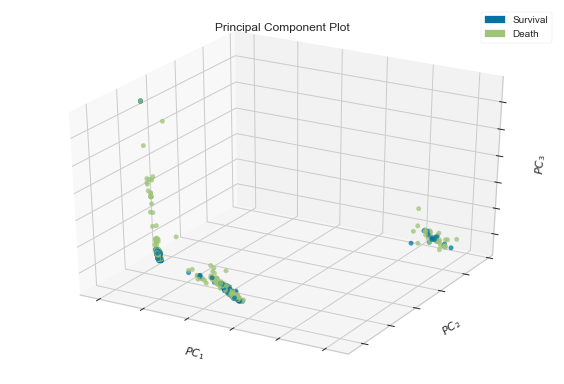

In [104]:
PCA_vision_3D_out(X_out_extra, y_out_extra.astype('int'))

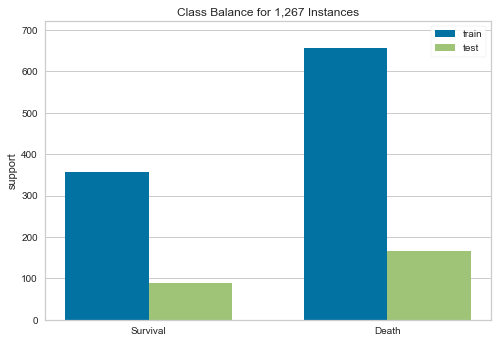

In [105]:
X_out_extra_train, X_out_extra_test, y_out_extra_train, y_out_extra_test = train_test_split(X_out_extra, y_out_extra, test_size=0.2, random_state=123, stratify=y_out_extra)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_extra_train, y_out_extra_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

In [106]:
# standardize age for df_out_extra

scaler2 = StandardScaler()
X_out_extra_train['age'] = scaler1.fit_transform(X_out_extra_train['age'].to_numpy().reshape(-1, 1))  
X_out_extra_test['age'] = scaler1.transform(X_out_extra_test['age'].to_numpy().reshape(-1, 1))

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### ML model here

In [107]:
extra_decision_tree_out = tree.DecisionTreeClassifier(random_state=123)
param_test = {
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 26)],
    'max_leaf_nodes':[i for i in range(6, 17)]
}

In [108]:
gsearch = GridSearchCV(
    estimator= extra_decision_tree_out,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=-1,
    iid=False,
    cv=5
)
gsearch.fit(X_out_extra_train, y_out_extra_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_leaf_nodes': [6, 7, 8, 9, 10,

In [289]:
clf_best_extra_tree_out = tree.DecisionTreeClassifier(
    random_state=123, 
    max_depth=         gsearch.best_params_['max_depth'], 
    min_samples_split= gsearch.best_params_['min_samples_split'],
    max_leaf_nodes=    gsearch.best_params_['max_leaf_nodes']
)
clf_best_extra_tree_out.fit(X_out_extra_train, y_out_extra_train)
y_out_extra_pred = clf_best_extra_tree_out.predict(X_out_extra_test)
accuracy_test = accuracy_score(y_out_extra_test, y_out_extra_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_extra_test, y_out_extra_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

0.5482805583929179

## Third proposition of data frame for outcome 

In [110]:
df_rid

,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,G10,35.0,-1,-1,0,1,0,1,1,1,...,0,1,0,1,0,-1,0,1,0,1
1,G100,40.0,-1,101,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1
2,G1000,40.0,260,-1,1,0,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
3,G1001,8.0,260,262,0,1,0,1,0,1,...,0,1,0,1,0,-1,0,1,0,1
4,G1002,12.0,258,262,0,1,0,1,1,1,...,1,0,1,0,0,-1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716,G995,30.0,-1,-1,0,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1
1717,G996,43.0,-1,261,1,0,0,0,0,1,...,0,1,0,1,0,-1,0,1,0,1
1718,G997,34.0,-1,262,0,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,0
1719,G998,6.0,-1,260,1,0,0,1,0,0,...,0,1,0,1,0,-1,0,1,0,1


First concatenate df_outcome (cleaned, but we need to still remove -1 "the unknwons") with msfid, in order to merge with df_rid 



In [111]:
df_outcome = df_outcome.astype('int')
df_temp = pd.concat([df_outcome, df_linelist['msfid']], axis = 1, join = 'outer')
df_temp

,outcome,msfid
0,1,G1
1,1,G10
2,0,G100
3,1,G1000
4,1,G1001
...,...,...
2495,1,G995
2496,1,G996
2497,-1,G997
2498,1,G998


In [112]:
df_out_rid = df_temp[df_temp['outcome'] != -1]
df_out_rid = df_out_rid.merge(df_rid,on = 'msfid')
# We predict the outcome only on ebola postive people, by outcome we mean (dead, not dead)
df_out_rid['epistat'] =df_out_rid['epistat'].replace(0, np.nan)
df_out_rid.dropna(axis = 0, inplace = True)
df_out_rid

,outcome,msfid,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,...,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes,epistat
0,1,G10,35.0,-1,-1,0,1,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1,0,G100,40.0,-1,101,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
2,1,G1000,40.0,260,-1,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
3,1,G1001,8.0,260,262,0,1,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0
4,0,G1002,12.0,258,262,0,1,0,1,1,...,1,0,1,0,0,-1,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1,G994,26.0,-1,261,1,0,0,1,1,...,0,1,0,1,0,-1,0,1,0,1.0
1166,1,G995,30.0,-1,-1,0,1,0,0,1,...,0,1,0,1,0,-1,0,1,0,1.0
1167,1,G996,43.0,-1,261,1,0,0,0,0,...,0,1,0,1,0,-1,0,1,0,1.0
1168,1,G998,6.0,-1,260,1,0,0,1,0,...,0,1,0,1,0,-1,0,1,0,1.0


In [113]:
# Let's drop msfid and epistat

df_out_rid.drop(['msfid','epistat'], inplace= True, axis = 1)


In [114]:
# This is now the third dataframe to predict the outcome knowing your patient is positive 
df_out_rid

,outcome,age,datmac_dayofyear,datgck_dayofyear,sex_F,sex_M,sex_U,symfev,symvom,symdiar,...,conttyp_Alive,conttyp_Dead,conttyp_Unknown,funvis_No,funvis_Unknown,funvis_Yes,fundat_dayofyear,funcont_No,funcont_Unknown,funcont_Yes
0,1,35.0,-1,-1,0,1,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1,0,40.0,-1,101,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0
2,1,40.0,260,-1,1,0,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
3,1,8.0,260,262,0,1,0,1,0,1,...,0,0,1,0,1,0,-1,0,1,0
4,0,12.0,258,262,0,1,0,1,1,1,...,0,1,0,1,0,0,-1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1,26.0,-1,261,1,0,0,1,1,1,...,0,0,1,0,1,0,-1,0,1,0
1166,1,30.0,-1,-1,0,1,0,0,1,1,...,0,0,1,0,1,0,-1,0,1,0
1167,1,43.0,-1,261,1,0,0,0,0,1,...,0,0,1,0,1,0,-1,0,1,0
1168,1,6.0,-1,260,1,0,0,1,0,0,...,0,0,1,0,1,0,-1,0,1,0


In [115]:
# For ridha's dataframe for yeah 
X_out_ml = df_out_rid.drop(columns = ['outcome'])
y_out_ml = df_out_rid['outcome']

#### We note that this column has only zero and we'll drop it

In [116]:
X_out_ml['respref_Dinguiraye'].value_counts()

0    1137
Name: respref_Dinguiraye, dtype: int64

In [117]:
X_out_ml.drop(columns=['respref_Dinguiraye'], inplace = True)

#### Correlation matrix 

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


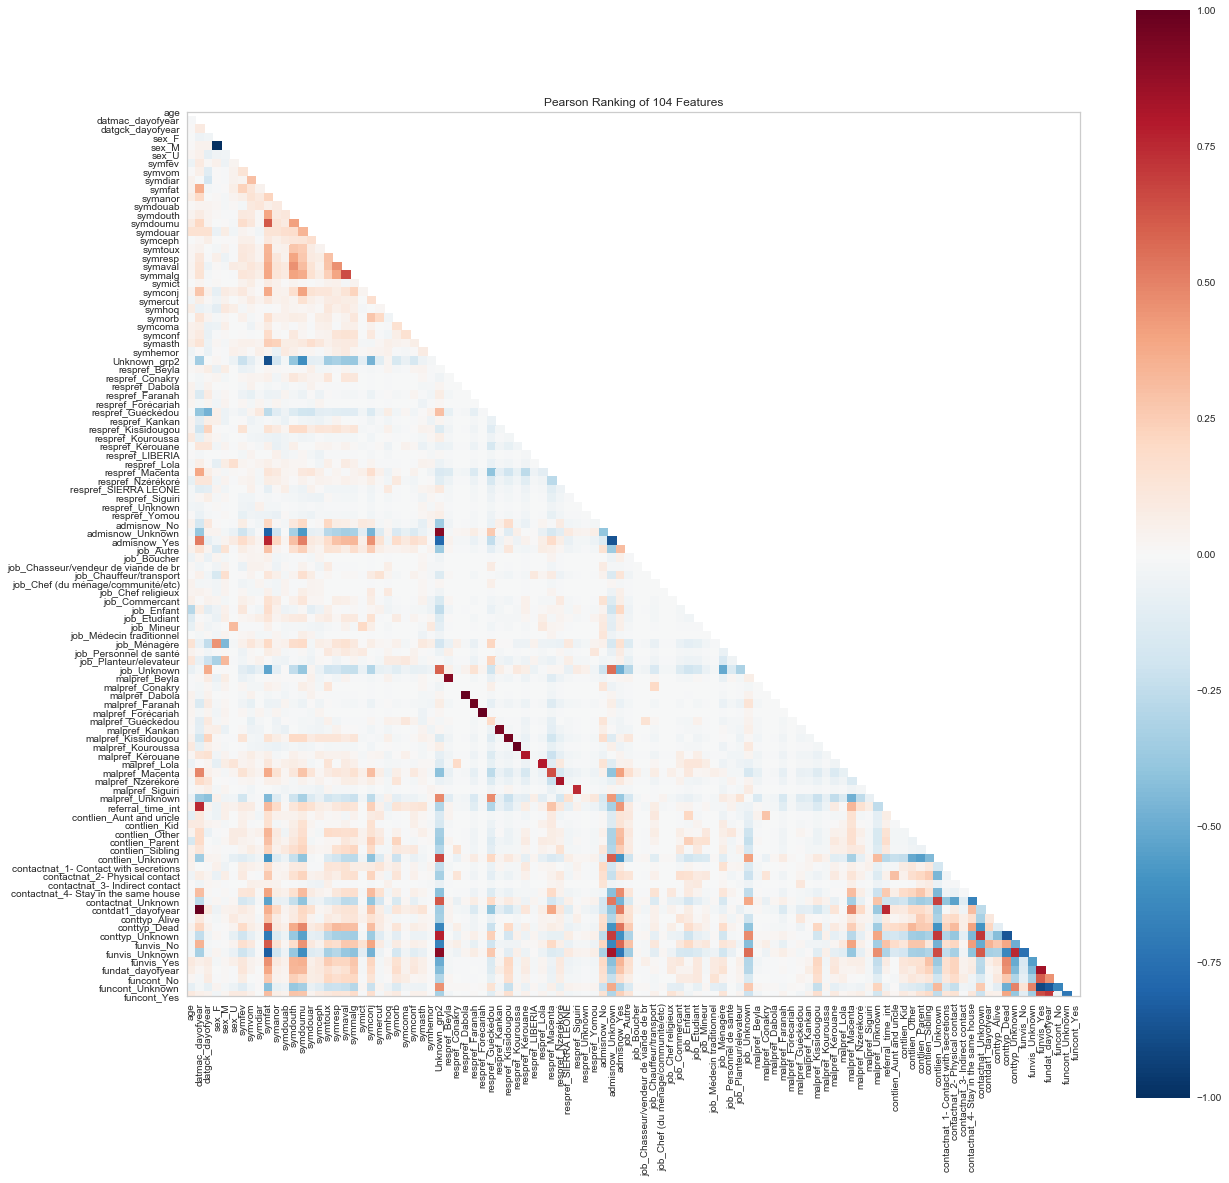

In [118]:
Corr_vision(X_out_ml)

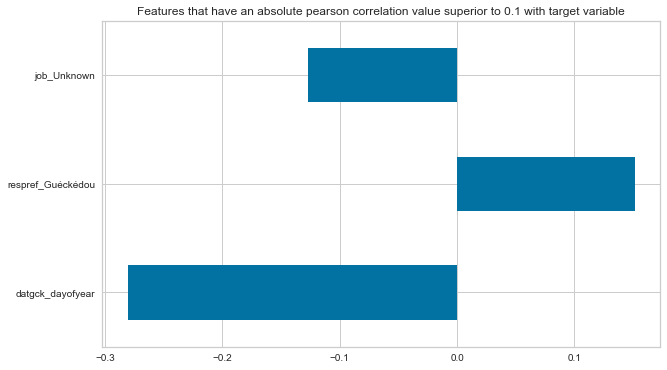

In [119]:
X_y_out = X_out_ml.join(y_out_ml, how = 'outer')
corr_matrix = X_y_out.corr()

corr_y = corr_matrix['outcome']
threshold = 0.1
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()



### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

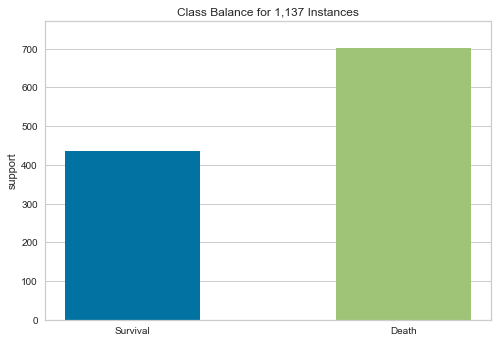

In [120]:
Imbalance_out(y_out_ml)

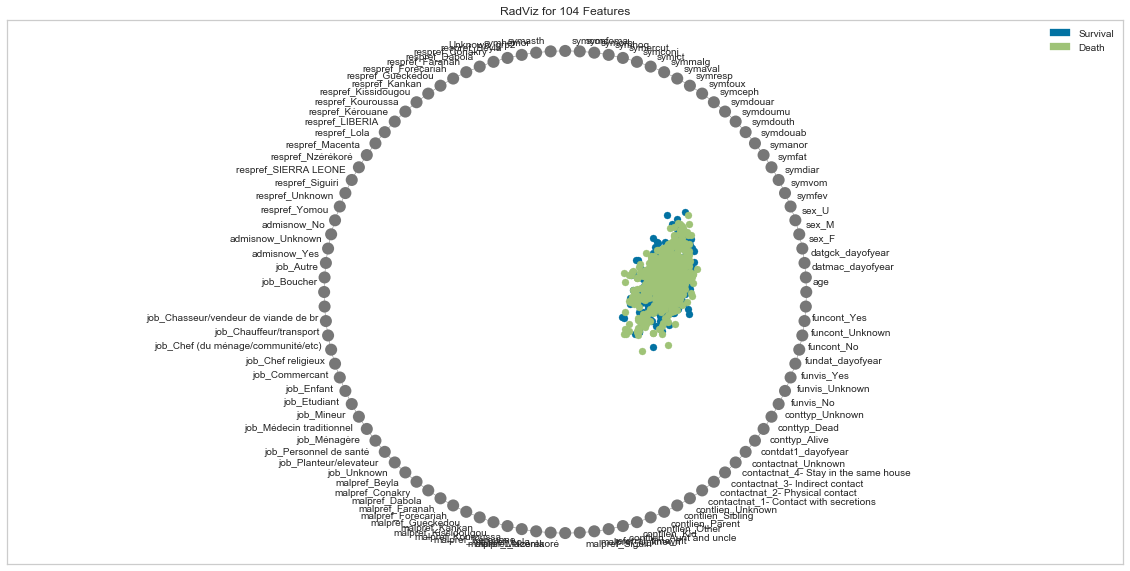

In [121]:
Rad_vision_out(X_out_ml, y_out_ml)

The plot above does not tell us much, we would have wished for a distinction of colors between ebola positive and negative patients

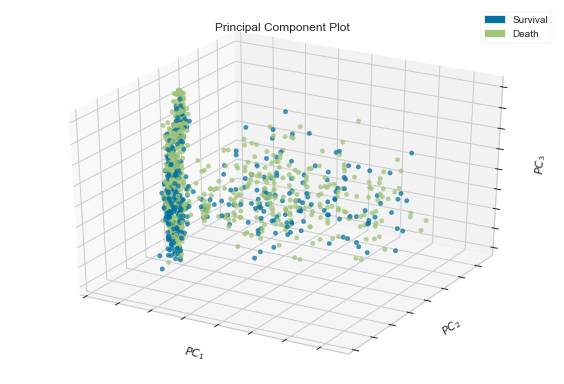

In [122]:
PCA_vision_3D_out(X_out_ml, y_out_ml)

#### We are in a high dimension dataset, let's try Manifold

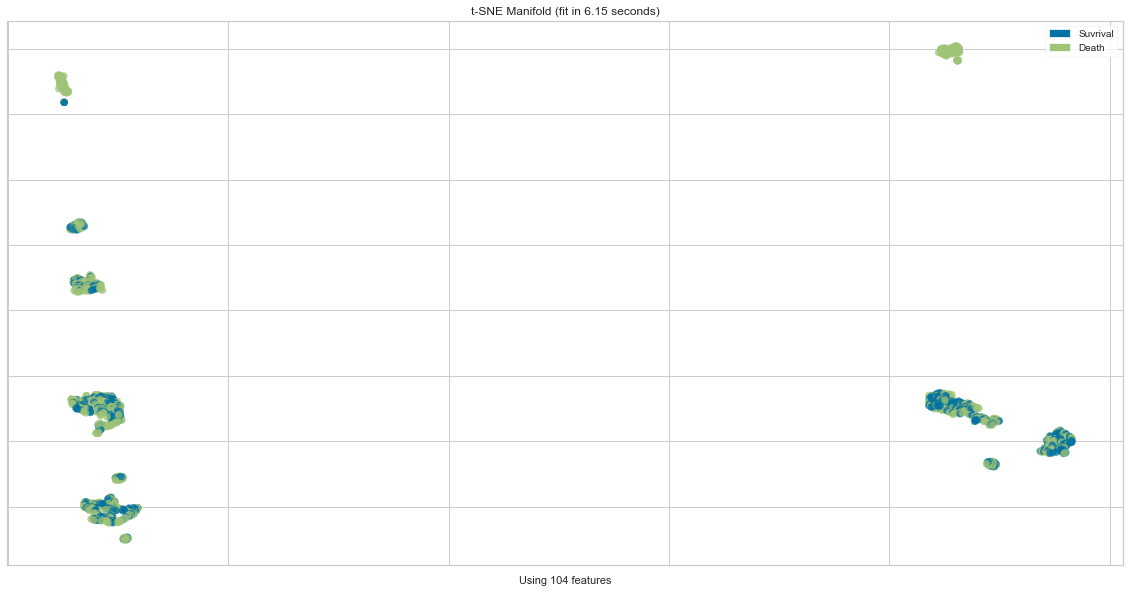

In [123]:
fig, ax = plt.subplots(figsize=(20,10))
# Instantiate the visualizer
viz = Manifold(manifold="tsne",  classes=['Suvrival', 'Death'])
viz.fit_transform(X_out_ml, y_out_ml)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure
plt.show()

##### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

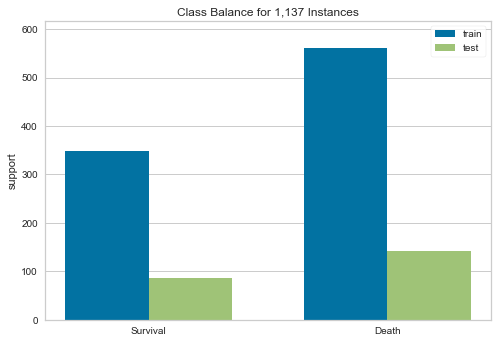

In [124]:

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out_ml, y_out_ml, test_size=0.2, random_state=123, stratify=y_out_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_train, y_out_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [125]:
scaler3 = StandardScaler()
numerical_col = ['age','datmac_dayofyear', 'datgck_dayofyear', 'referral_time_int', 'contdat1_dayofyear','fundat_dayofyear']
X_out_train.loc[:,numerical_col] = scaler3.fit_transform(X_out_train[numerical_col])
X_out_test.loc[:,numerical_col] = scaler3.transform(X_out_test[numerical_col])

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### SVM

Use of validation curve to determine a plausible area for the hyper-parameters
- gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
- C: Regularization parameter (the strength of the regularization is inversely proportional to C)
- kernel: kernel type to be used in the algorithm

For a linear kernel, we just need to optimize the c parameter. However, if we want to use an RBF kernel, both c and gamma parameter need to optimized simultaneously.
So in our case we tune both hyperparameters.

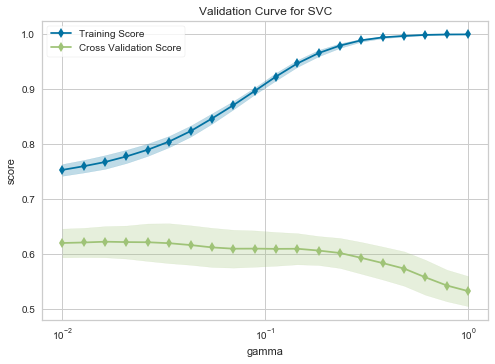

In [127]:
# Validation curve for gamma parameter 
cv = cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=123)
#cv = cv = StratifiedKFold(n_splits=5, random_state=123)

param_range = np.logspace(-2, 0, 20)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

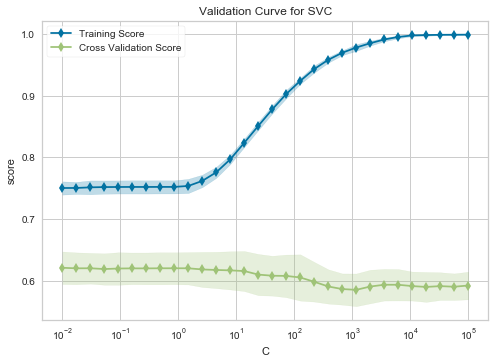

In [128]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=123)
#cv = cv = StratifiedKFold(n_splits=5, random_state=123)
param_range = np.logspace(-2, 5, 30)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [129]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(0, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc = svm.SVC(random_state=123)

clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf.fit(X_out_train, y_out_train)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1c1f638890>,
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False)...
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       

In [130]:
clf.best_params_

{'C': 2.2122162910704493, 'gamma': 0.01373823795883263, 'kernel': 'poly'}

SVC:
On training we get an Accuracy 0.6204620462046204, an AUC 0.5043103448275862 and F1 score 0.7648261758691206 
For test we get an Accuracy 0.618421052631579, an AUC 0.5 and F1 score 0.7642276422764228


/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Can plot ROC curve for this model
Don't have feature importance


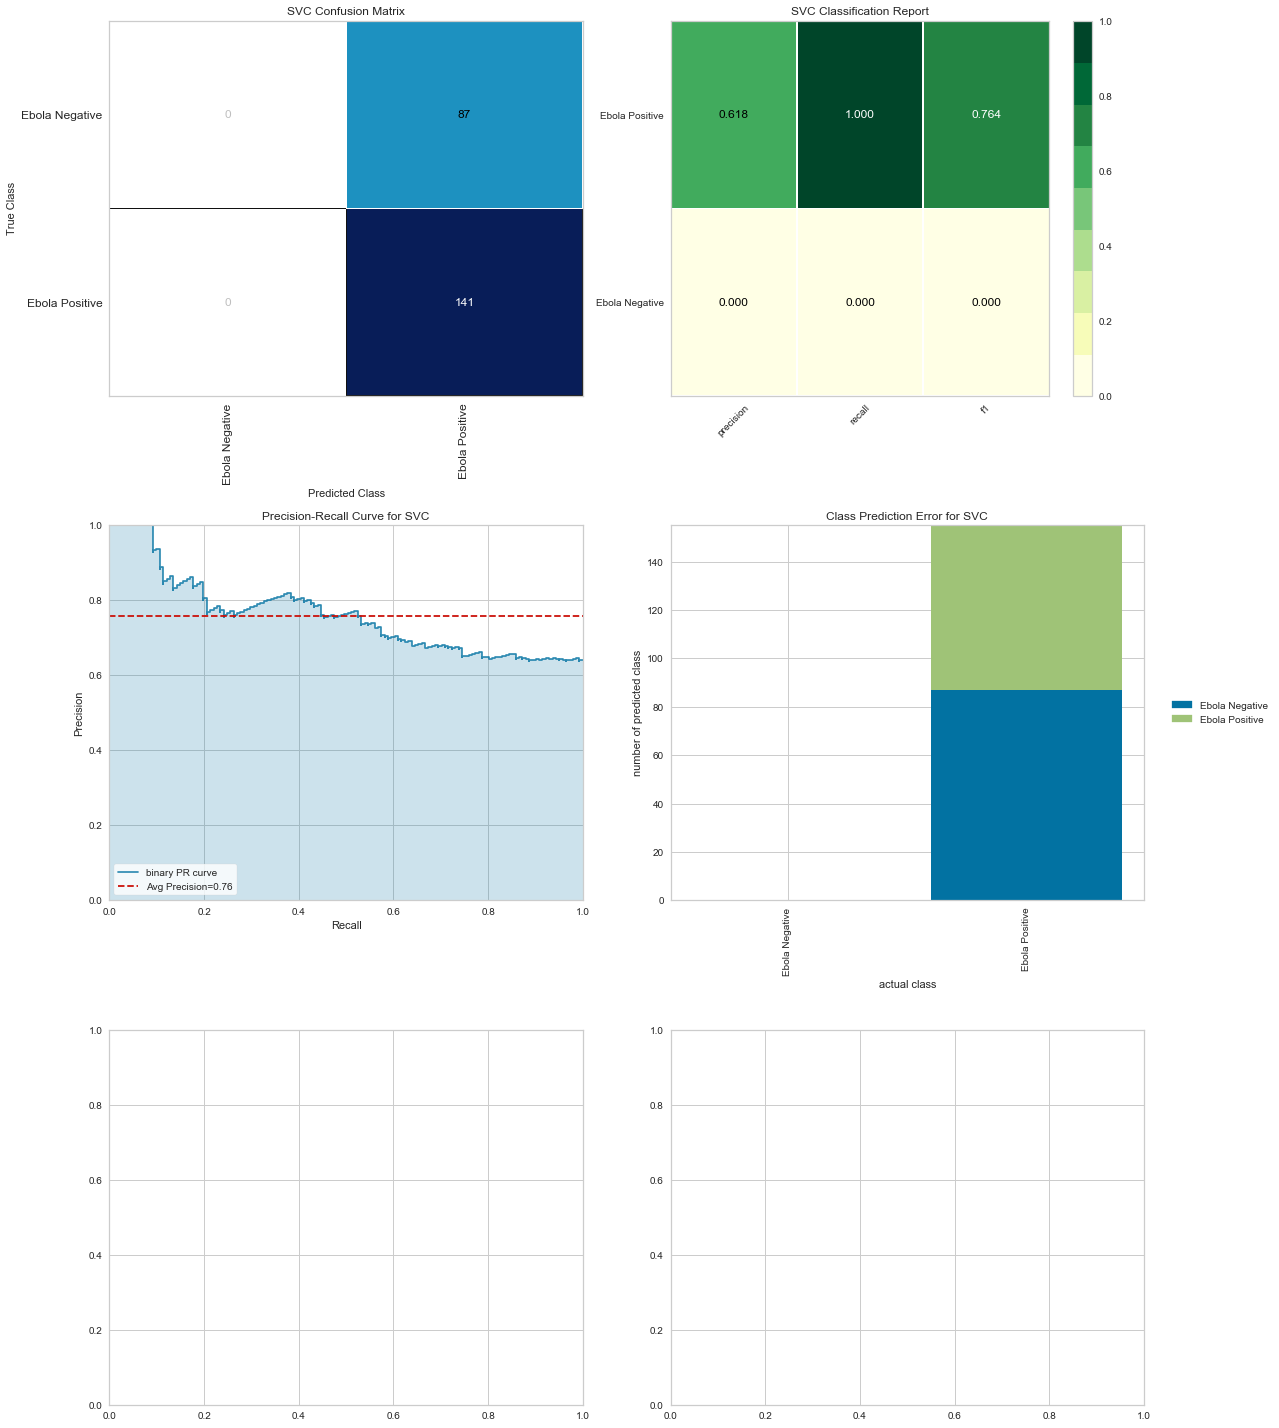

In [131]:
svc = svm.SVC(
    random_state=123,
    C= clf.best_params_['C'], 
    gamma = clf.best_params_['gamma'], 
    kernel = clf.best_params_['kernel']
)
score_model_outcome(X_out_train, y_out_train, X_out_test, y_out_test, svc)

In [132]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=123)
#cv = StratifiedKFold(n_splits=2, random_state=123)

parameters = {'C': np.logspace(0, 2, 30), 'gamma' : np.logspace(-2, 0, 30)}
svc_linear = svm.SVC(random_state=123)

clf_linear = GridSearchCV(svc_linear, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf_linear.fit(X_out_train, y_out_train)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1c212db950>,
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False)...
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [133]:
clf_linear.best_params_

{'C': 6.7233575364993365, 'gamma': 0.0117210229753348}

SVC:
On training we get an Accuracy 0.7018701870187019, an AUC 0.644454176654988 and F1 score 0.7864460204885737 
For test we get an Accuracy 0.6096491228070176, an AUC 0.5501345072144779 and F1 score 0.7174603174603175
Can plot ROC curve for this model
Don't have feature importance


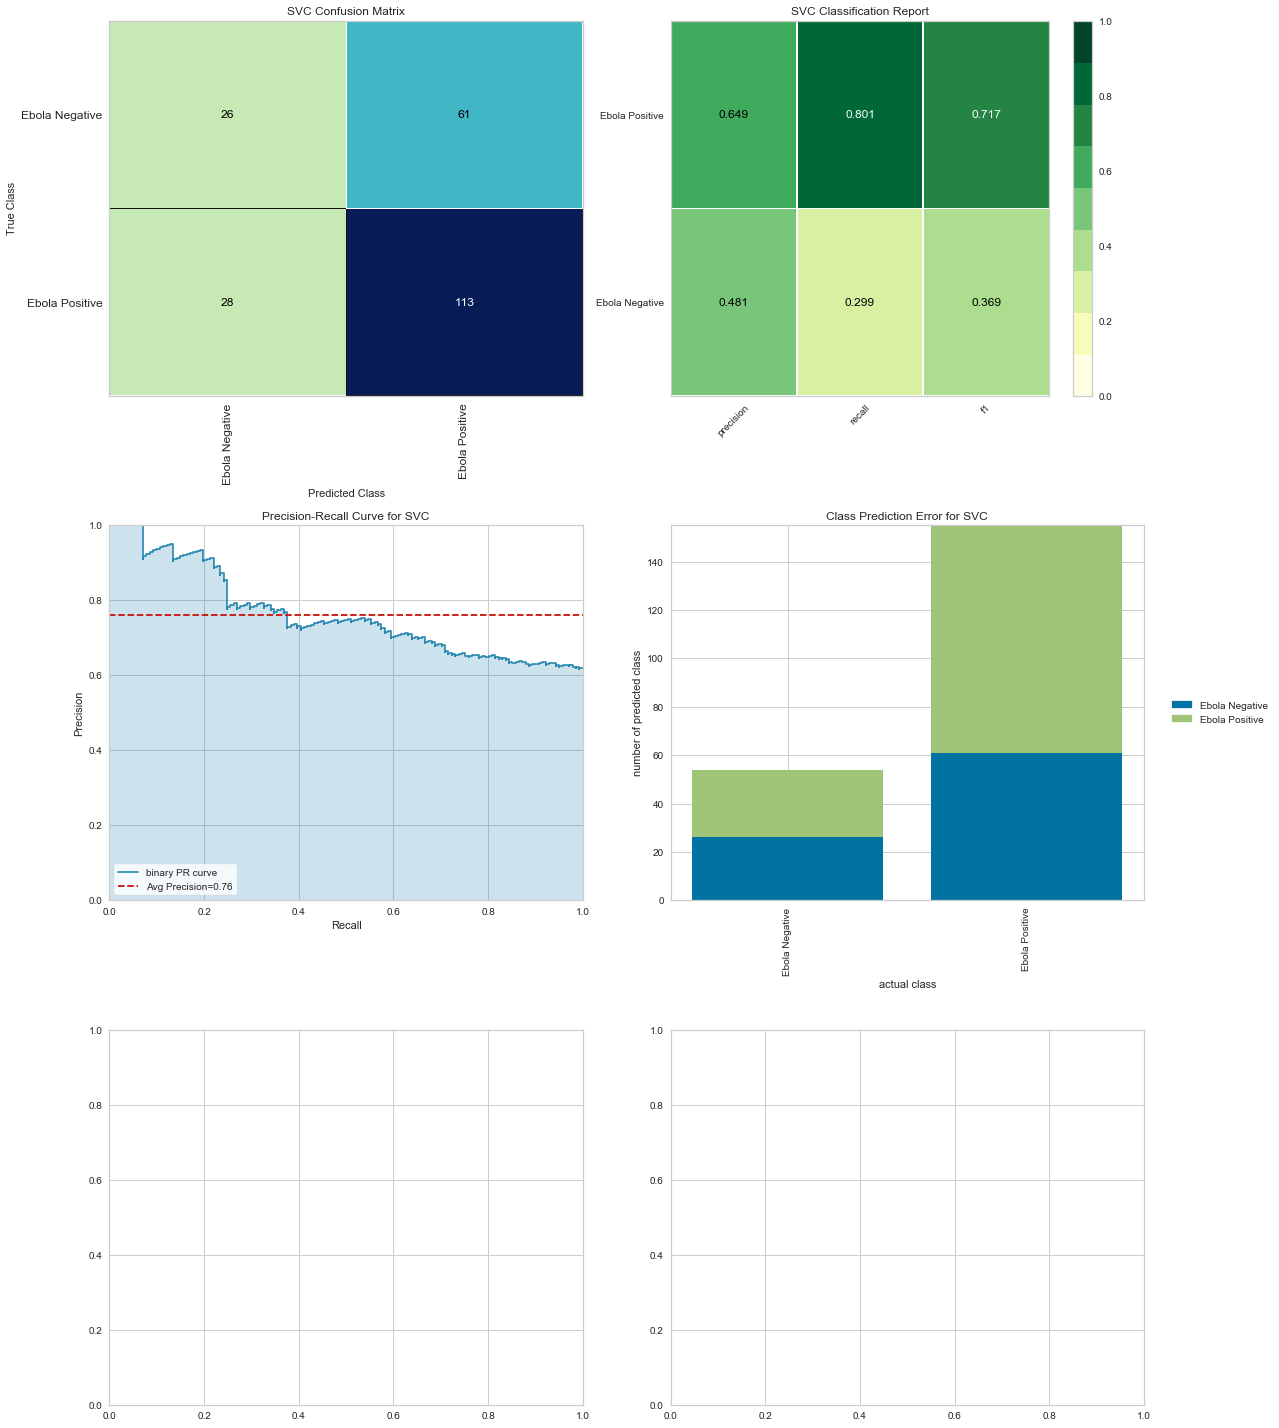

In [134]:
svc_linear = svm.SVC(
    random_state = 123,
    C =      clf.best_params_['C'], 
    gamma =  clf.best_params_['gamma'], 
    kernel = 'linear')
score_model_outcome(X_out_train, y_out_train, X_out_test, y_out_test, svc_linear)

In [135]:
eli5.show_weights(svc_linear, feature_names=list(X_out_ml.columns))

Weight?,Feature
+1.575,symconf
+1.211,respref_Unknown
+1.198,job_Chasseur/vendeur de viande de br
+1.147,malpref_Faranah
+1.097,symaval
+0.962,malpref_Kissidougou
+0.826,malpref_Kérouane
+0.788,symorb
+0.777,symconj
+0.687,malpref_Lola


/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


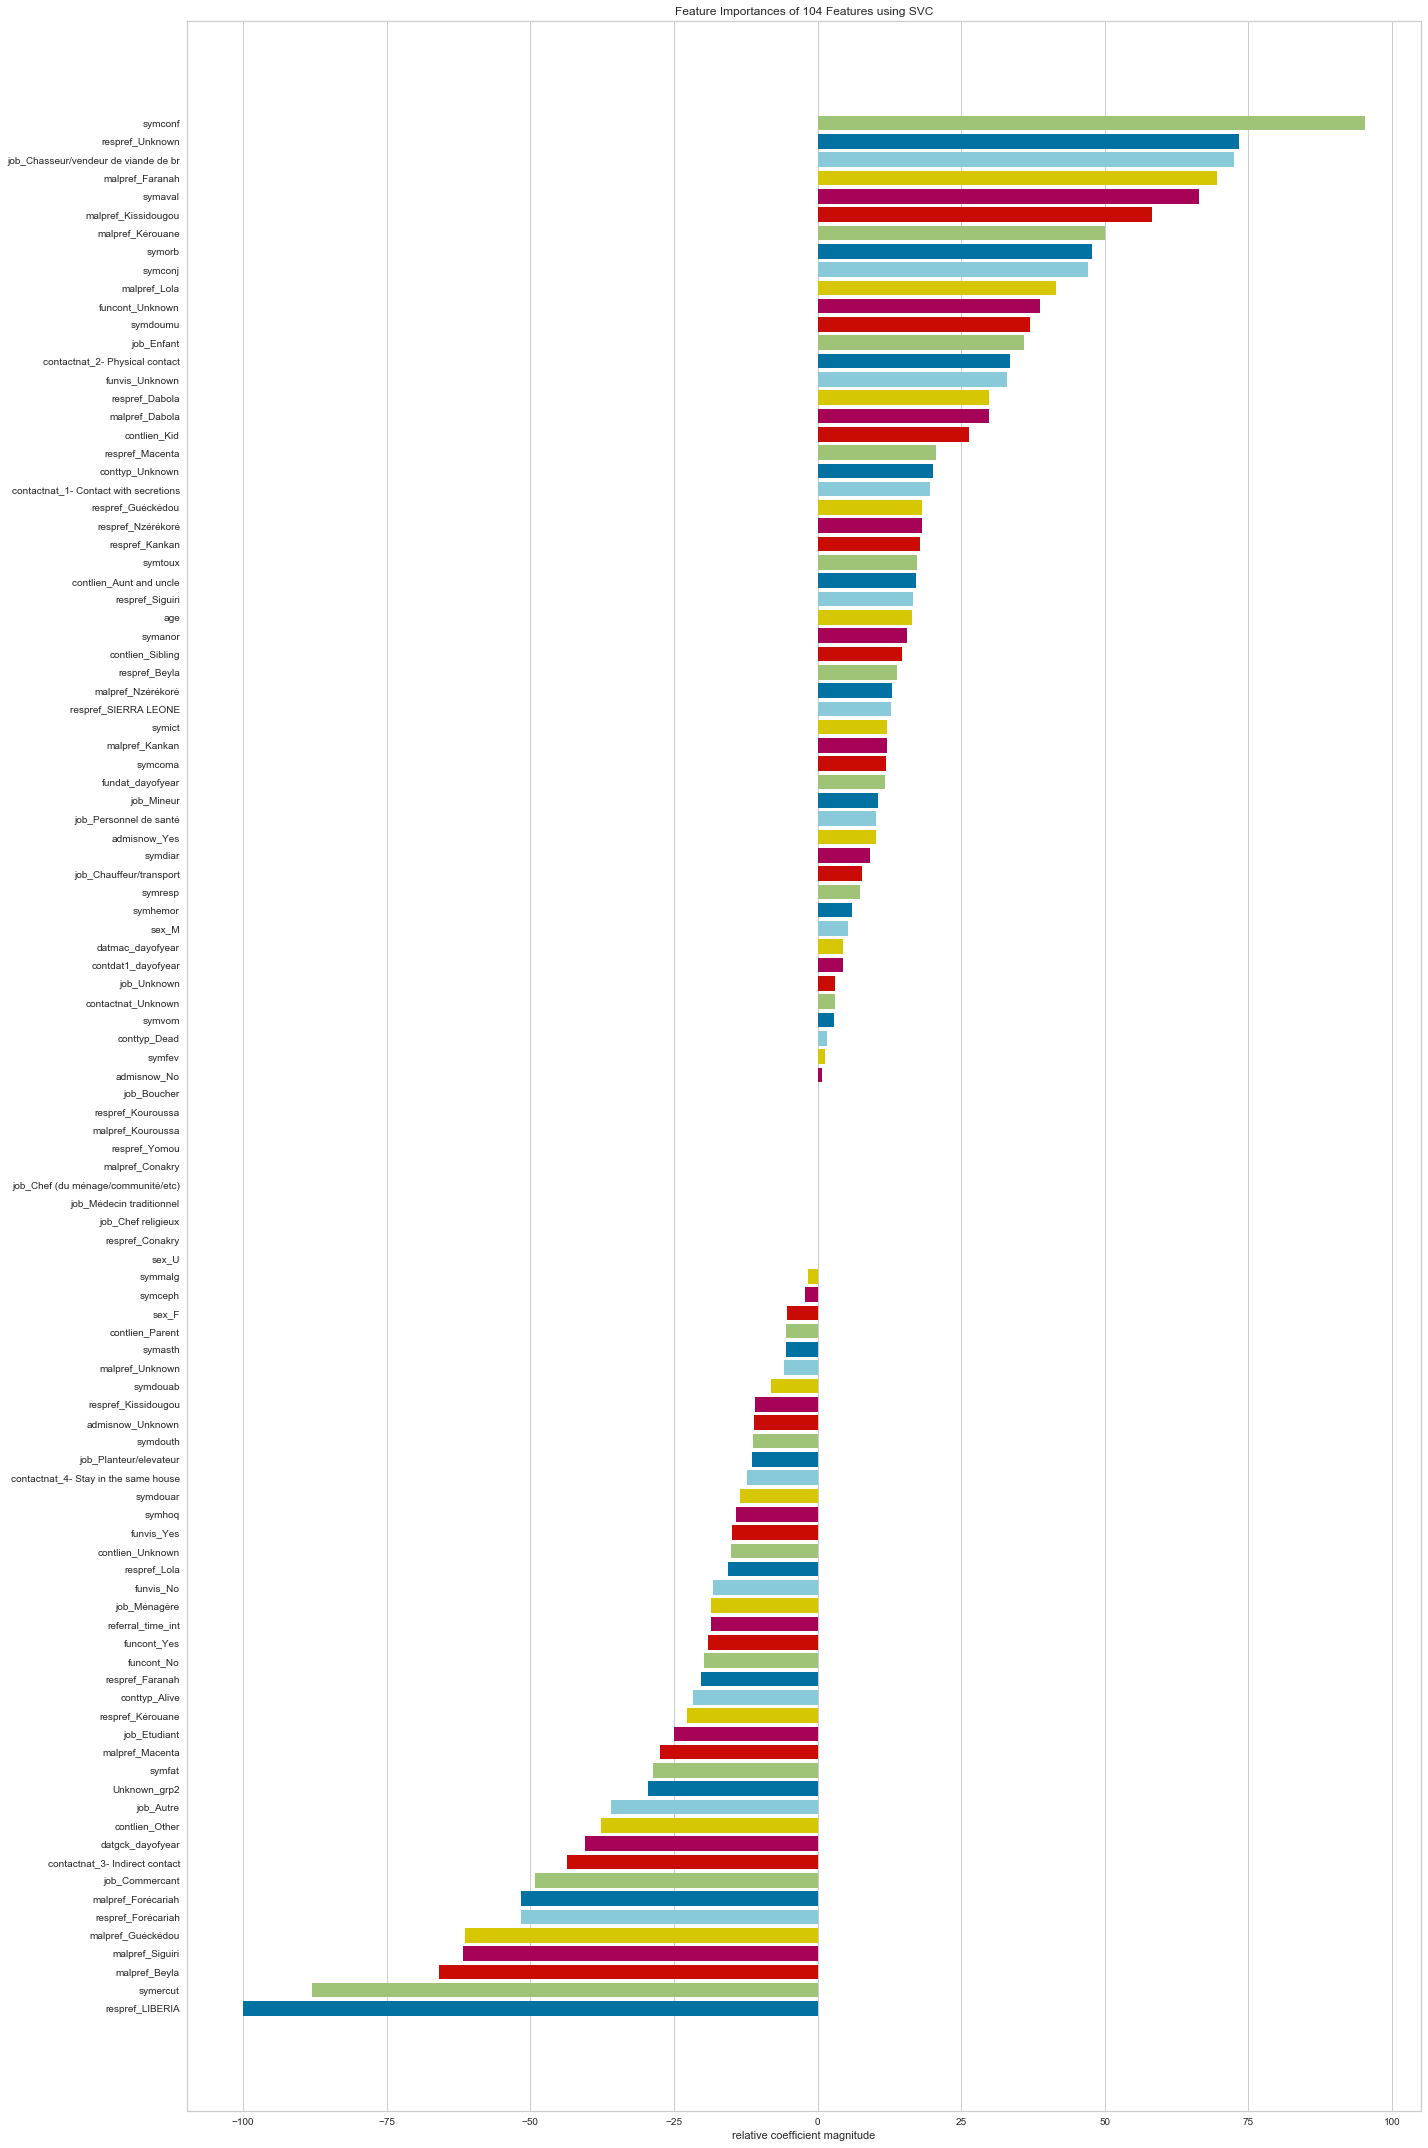

In [136]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(svc_linear, relative=True)
viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

### Logistic regression

 Use of validation curve to determine a plausible area for the hyper-parameters:
- penalty: norm used for the penalization
- C: inverse of regularization strength

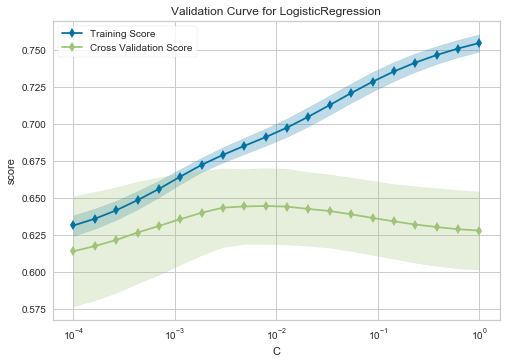

In [137]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(LogisticRegression(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [138]:
parameters = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-3, -1, 30)}
logit = LogisticRegression(random_state=123)

clf = GridSearchCV(logit, parameters, scoring = 'roc_auc', n_jobs=-1, cv=cv)
clf.fit(X_out_train, y_out_train)

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1c1d194f10>,
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=123, solver='warn',
                                          tol=0.0001, verbose=0...
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 0.06210169, 0.07278954, 0.08531679, 0.1       ]),
             

In [139]:
clf.best_params_

{'C': 0.1, 'penalty': 'l1'}

/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression:
On training we get an Accuracy 0.6336633663366337, an AUC 0.579376421414961 and F1 score 0.7320997586484312 
For test we get an Accuracy 0.5789473684210527, an AUC 0.520909757887014 and F1 score 0.6923076923076923


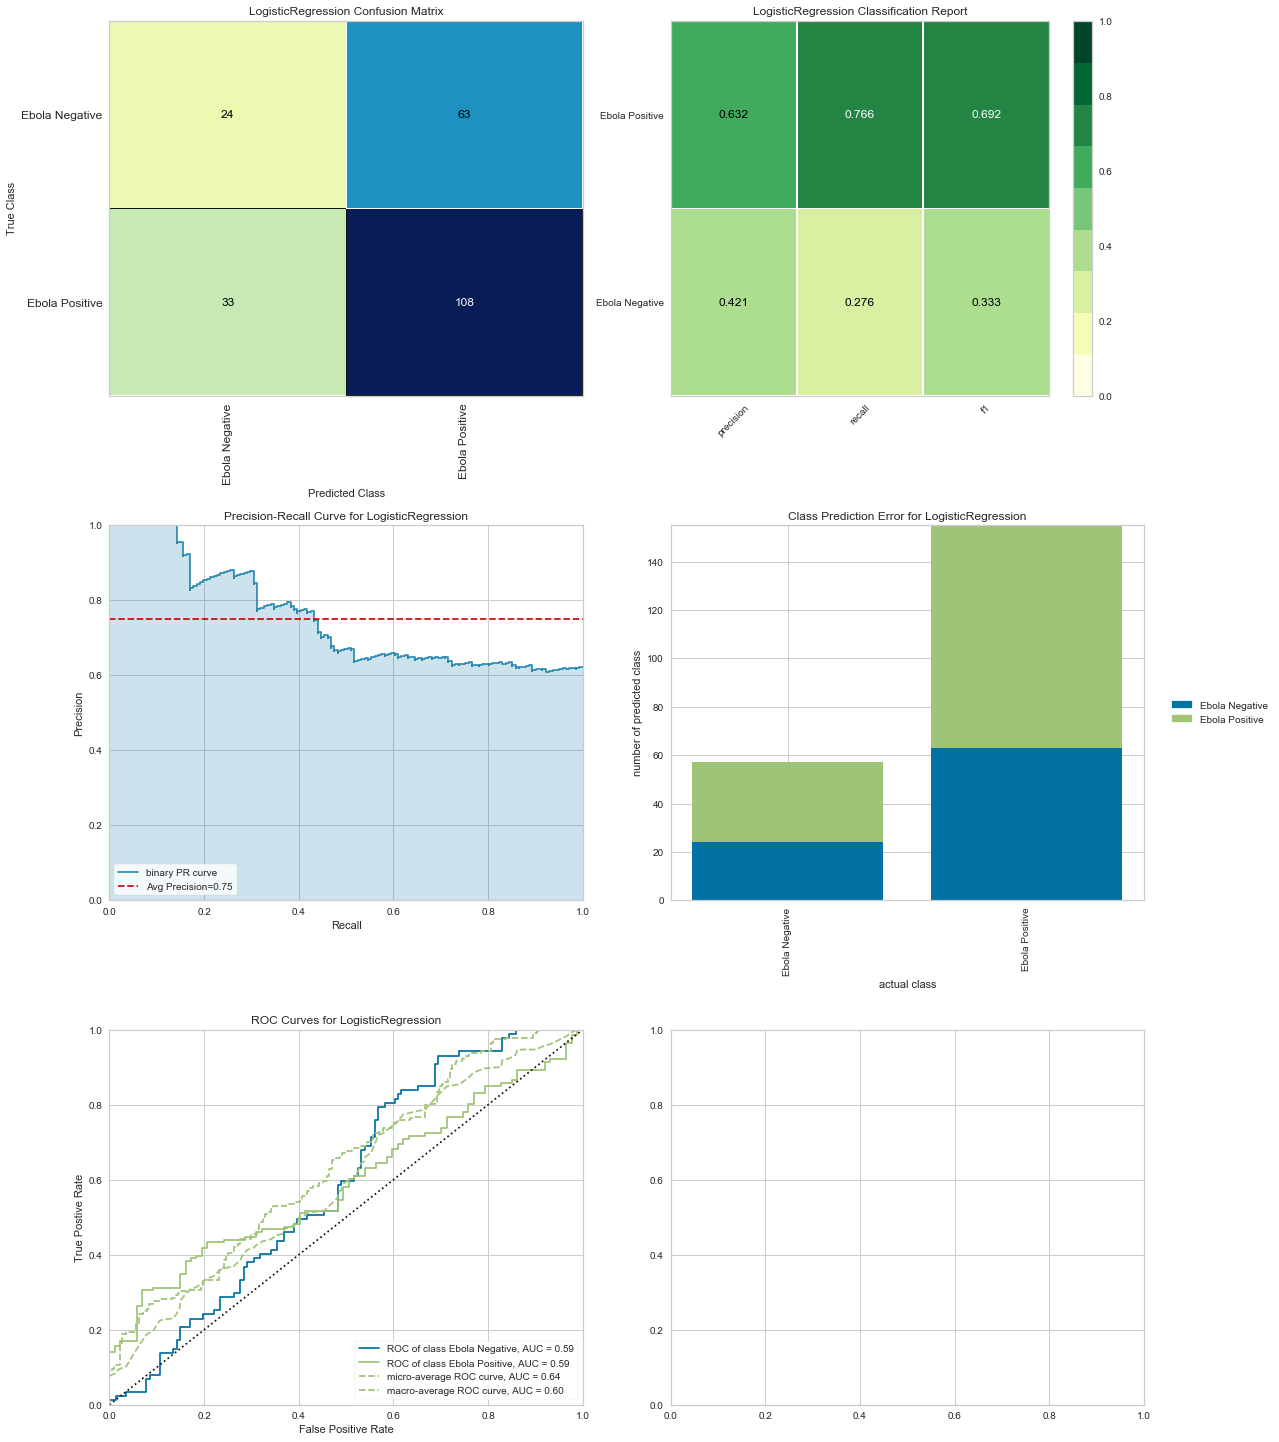

Don't have feature importance




In [140]:
logit = LogisticRegression(
    penalty = clf.best_params_['penalty'], 
    C = clf.best_params_['C']
)
score_model_outcome(X_out_train, y_out_train, X_out_test, y_out_test, logit)

Since results are not good let's verify that if we predict only 'death' the AUC will not be higher than our actual AUC.

In [165]:
prediction_test = np.ones(len(y_out_test))
accuracy_test = accuracy_score(y_out_test, prediction_test)
accuracy_test

0.618421052631579

Resultat un peu gênant....

In [141]:
eli5.show_weights(logit, feature_names=list(X_out_ml.columns))

Weight?,Feature
+0.323,<BIAS>
+0.139,age
+0.112,symdiar
+0.087,symanor
+0.062,funcont_Unknown
+0.026,sex_M
-0.073,referral_time_int
-0.662,datgck_dayofyear


/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


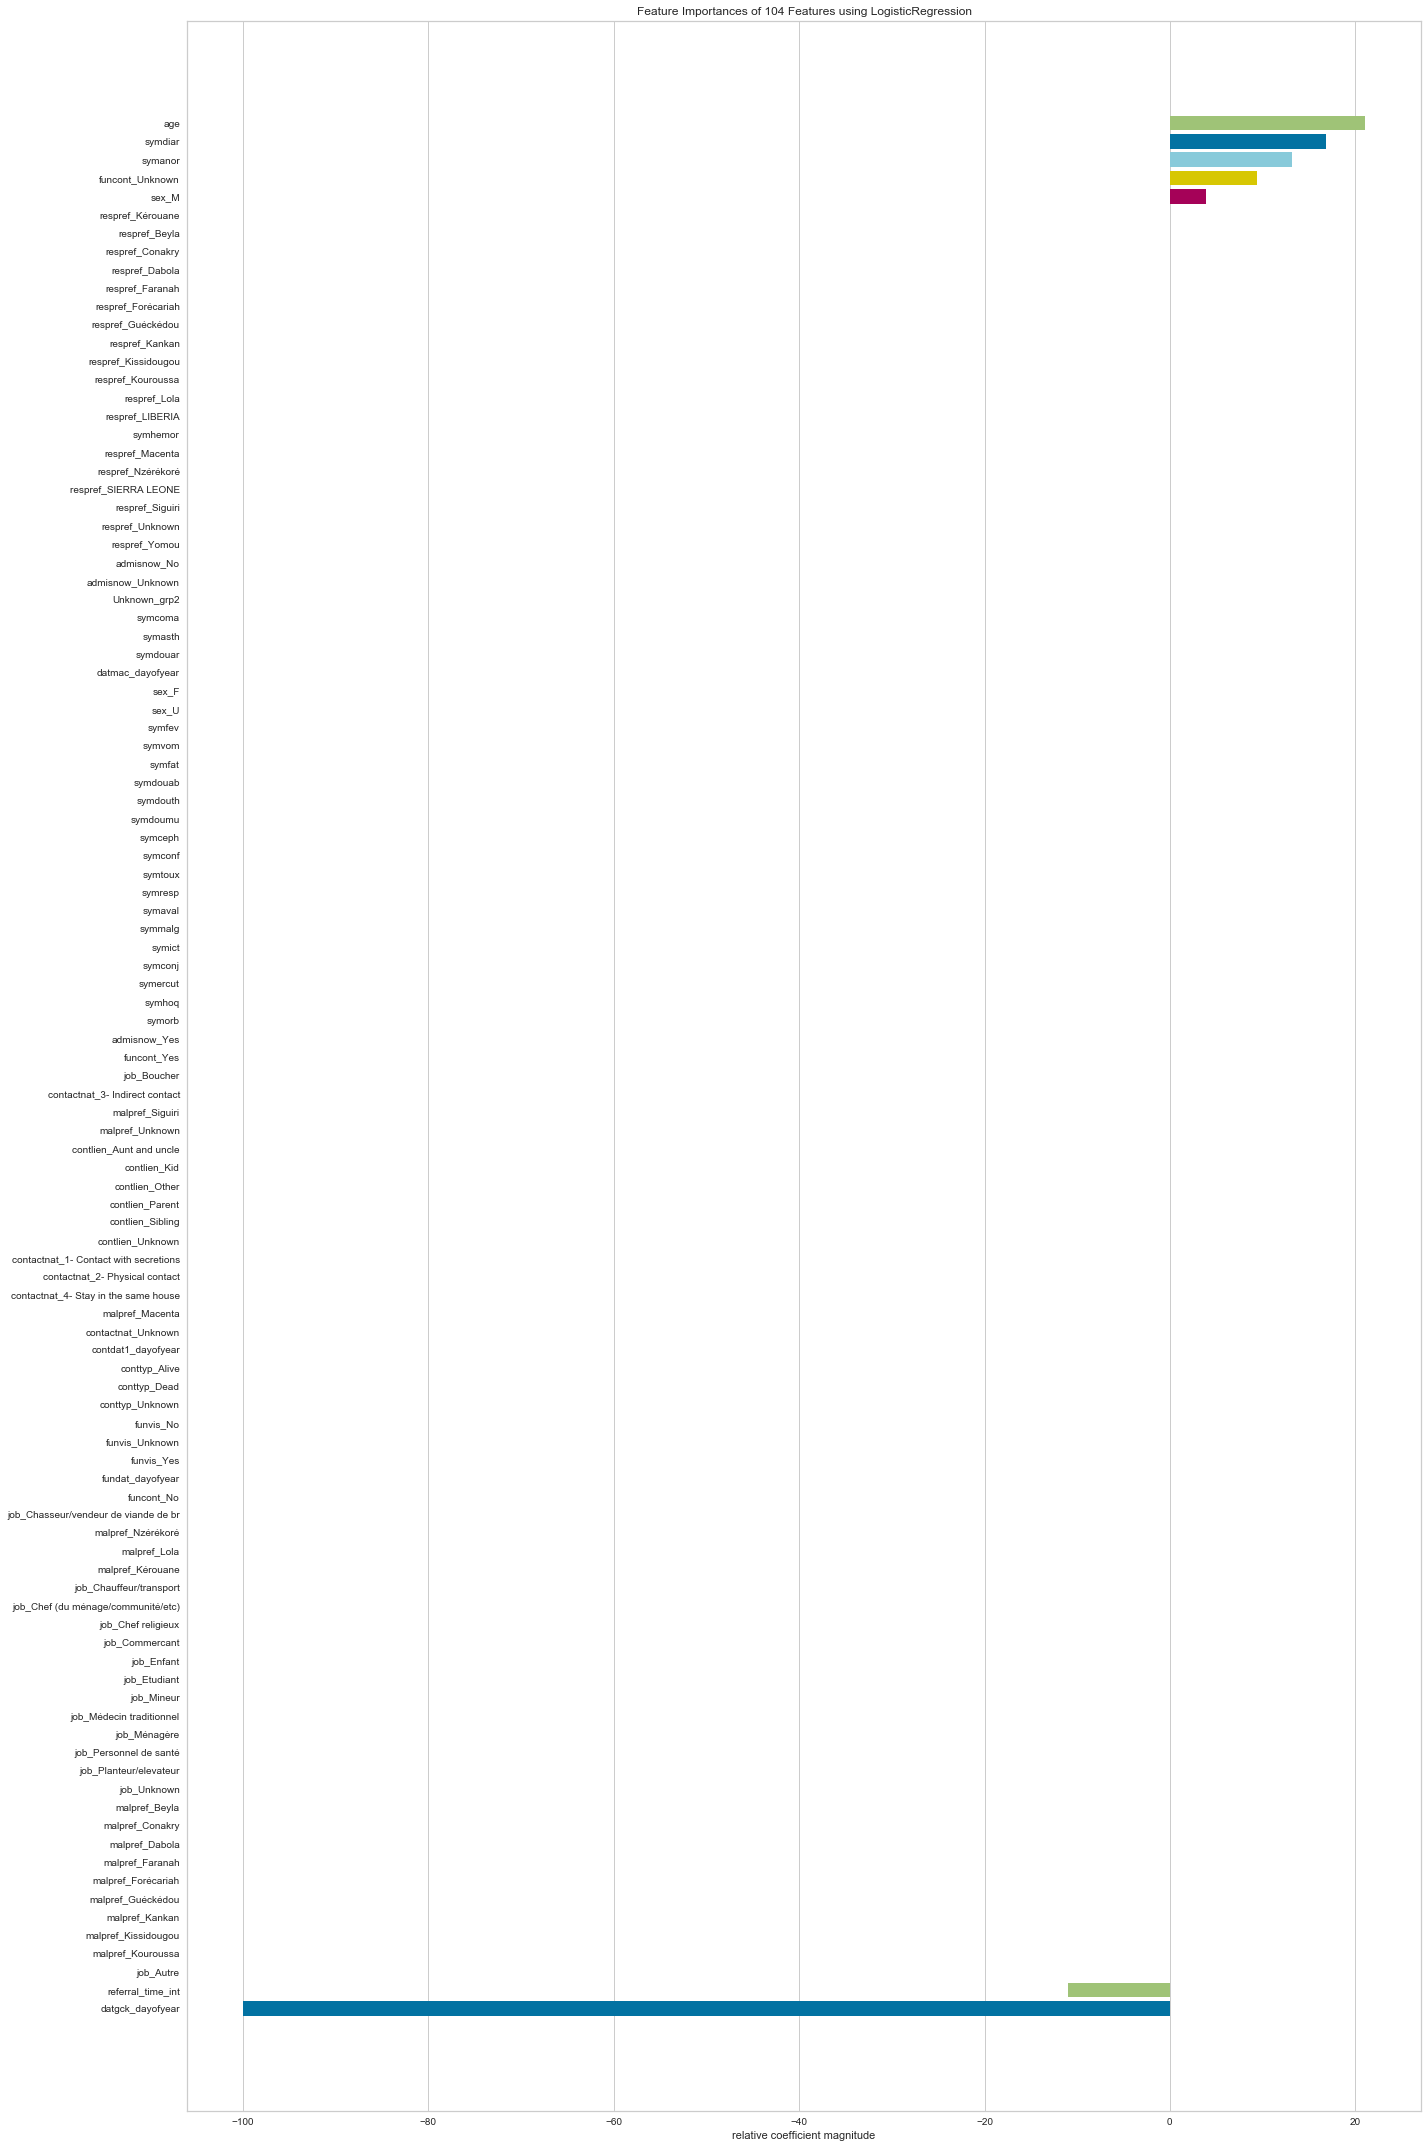

In [142]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(logit, relative=True)
viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

### Random Forest

 Use of validation curve to determine a plausible area for the hyper-parameters
- n_estimators: Number of trees to build
- max_depth: Maximum depth of tree
- min_samples_split: Data points in nodes before split occurs 

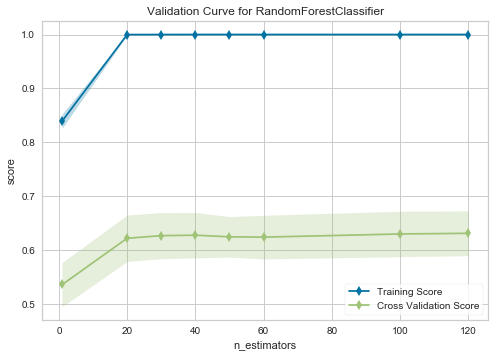

In [143]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=123)
param_range = [1,20,30, 40,50,60,100,120]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="n_estimators", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

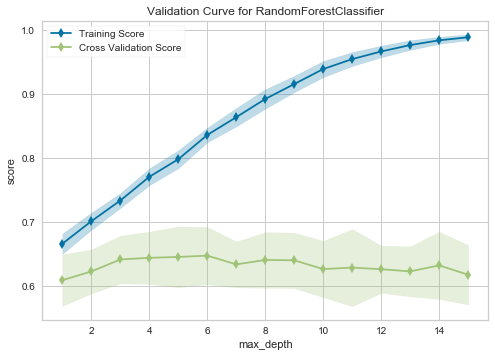

In [144]:
# For max_depth
param_range = [1,2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

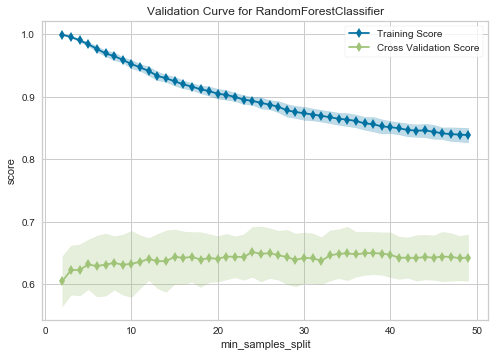

In [145]:
# For min_samples_split

param_range = range(2,50)

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

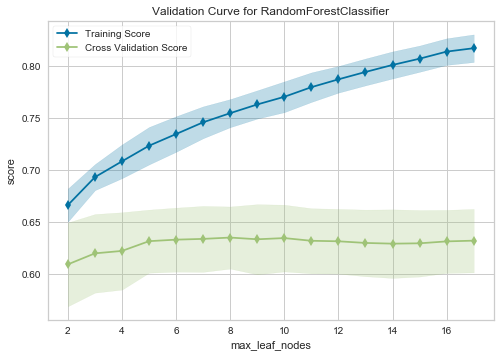

In [146]:
# For max_leaf_nodes
param_range = [2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15,16,17]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_leaf_nodes", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()


In [147]:
param_test = {
    'n_estimators':[30, 40, 50, 60, 100],
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 5)],
    'max_leaf_nodes':[i for i in range(2, 17)]
}
clforest = RandomForestClassifier(random_state = 123)

In [148]:
gsearch = GridSearchCV(
    estimator= clforest,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=cv
)
gsearch.fit(X_out_train, y_out_train)
print(gsearch.best_params_)

{'max_depth': 13, 'max_leaf_nodes': 16, 'min_samples_split': 4, 'n_estimators': 50}


In [290]:
clf_best = RandomForestClassifier(n_estimators=     gsearch.best_params_['n_estimators'], 
                                  max_depth=        gsearch.best_params_['max_depth'], 
                                  min_samples_split=gsearch.best_params_['min_samples_split'])
clf_best = clf_best.fit(X_out_train, y_out_train)
y_out_pred = clf_best.predict(X_out_test)
accuracy_test = accuracy_score(y_out_test, y_out_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_out_test, y_out_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test

0.5462215700660308

In [151]:
eli5.show_weights(clf_best, feature_names=list(X_out_ml.columns))

Weight,Feature
0.1809 ± 0.1610,datgck_dayofyear
0.1081 ± 0.0849,age
0.0530 ± 0.0559,contdat1_dayofyear
0.0521 ± 0.0590,datmac_dayofyear
0.0440 ± 0.0422,referral_time_int
0.0247 ± 0.0393,symdiar
0.0204 ± 0.0252,symanor
0.0187 ± 0.0302,symdouab
0.0165 ± 0.0193,symceph
0.0164 ± 0.0280,symfev


/Users/jeannafta/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


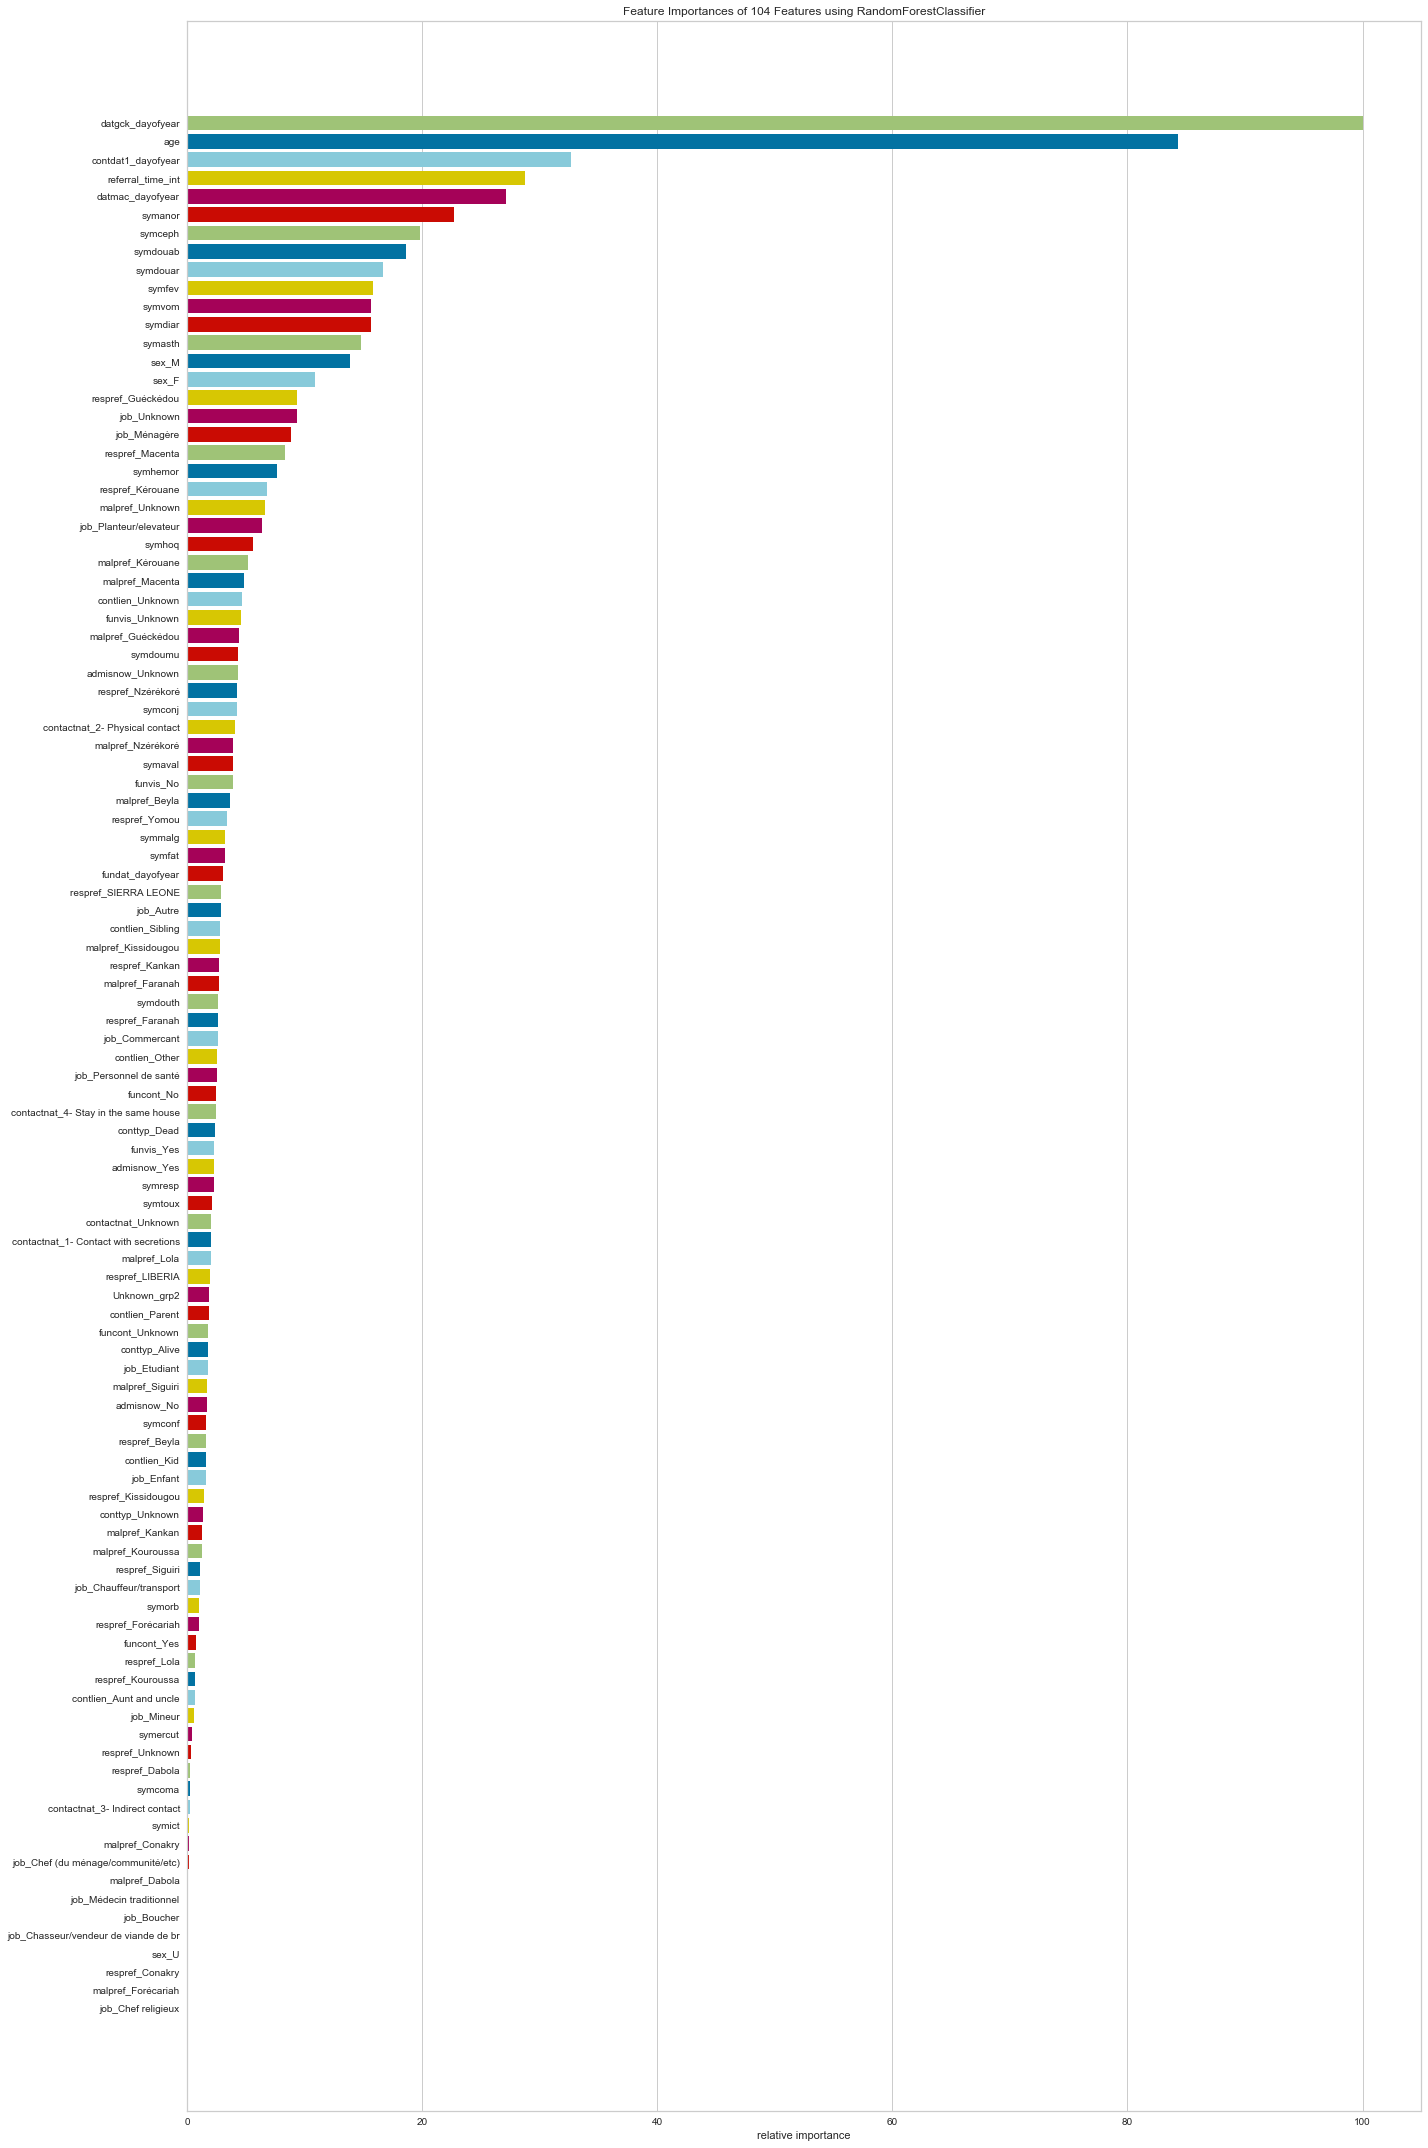

In [152]:
fig, ax = plt.subplots(figsize=(20,30))

viz = FeatureImportances(clforest, relative=True)
viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()